In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az

In [2]:
az.style.use('arviz-darkgrid')

# Programación probabilística

> Nuestros golems raramente tienen forma física, pero a menudo están hechos de arcilla y viven _in silicio_ como código de computadora -Richard McElreath

La estadística Bayesiana es conceptualmente muy simple, tenemos lo _conocido_ y lo _desconocido_. El teorema de Bayes se utiliza para condicionar lo desconocido usando lo conocido, si tenemos suerte este proceso conducirá a una reducción de la incertidumbre sobre lo desconocido. Por lo general nos referimos a lo conocido como datos y los consideramos fijo mientras que lo desconocido toma la forma de parámetros de distribuciones de probabilidad. La simpleza conceptual para formular modelos Bayesianos contrasta con la dificultad matemático/computacional para resolverlos. Por muchos años esto fue un verdadero problema y retrasó la adopción de métodos Bayesianos.

A fin de poder resolver los modelos Bayesianos se recurre a métodos numéricos que pueden ser considerados como _motores universales de inferencia_. El hecho que tales motores sean posibles ha motivado el surgimiento de la [programación probabilística](http://probabilistic-programming.org/wiki/Home), este tipo de lenguajes permiten una separación clara entre la creación de los modelos y el proceso de inferencia. 

Un lenguaje de programación probabilístico es, en lineas generales, un lenguaje que le permite al usuario describir, en una pocas lineas de código (las necesarias para describir el modelo), un modelo probabilístico completo. Luego se procede a utilizar este modelo para realizar la inferencia de forma automática. Se espera que la programación probabilística tenga un gran impacto en estadística, _machine learning_ y otras disciplinas al permitir que científicos construyan modelos complejos en menor tiempo y de forma menos propensa a errores.

Una buena analogía sobre el impacto que un lenguaje de programación puede tener en la ciencia es la introducción del lenguaje de programación Fortran hace más de 6 décadas. Fortran permitió a los científicos, por primera vez, abstraerse de muchos de los detalles computacionales y centrarse en la construcción de métodos numéricos, modelos y simulaciones de una manera más natural. De manera similar, se espera que los lenguajes de programación probabilísticos escondan del usuario detalles sobre cómo las probabilidades son manipuladas y cómo se lleva a cabo la inferencia, dejando que los usuarios se centren en la especificación del modelo y en el análisis e interpretación de los resultados.

## Objetivos de este capítulo

* Construir modelos con PyMC3
* Analizar modelos con PyMC3 y ArviZ
* Explorar formas alternativas de interpretar el _a posteriori_
* La importancia del tamaño del efecto vs la irrelavancia de la significancia. 
* Aprender sobre modelos jerárquicos
    * agrupamiento-parcial
    * efecto de _contracción_

## Introducción a PyMC3

PyMC3 es un paquete para programación probabilística bajo Python. PyMC3 es lo suficientemente madura para resolver muchos problemas estadísticos.  PyMC3 permite crear modelos probabilísticos usando una sintaxis intuitiva y fácil de leer que es muy similar a la sintaxis usada para describir modelos probabilísticos.

La mayoría de las funciones de PyMC3 están escritas en Python. Mientras que las partes computacionalmente demandantes están escritas en NumPy y [Theano](http://deeplearning.net/software/theano/index.html). Theano Es una librería de Python originalmente desarrollada para _deep learning_ (es la antesesora de TensorFlow, PyTorch, MXNet, etc). Theano permite definir, optimizar y evaluar, de forma eficiente, expresiones matemáticas que involucran arreglos multidimensionales. La principal razón por la cual PyMC3 utiliza Theano es debido a que ciertos métodos de muestreo requieren del cálculo de gradientes de funciones arbitrarias. Theano es capaz de hacer esto utilizando un método llamado diferenciación automática. Además, Theano compila código Python a C, haciendo que PyMC3 sea rápido. Esta es toda la información sobre Theano necesaria para poder usar PyMC3.

> Recientemente los desarrolladores de Theano anunciaron que dejarán de desarrollar y mantener esta librería. Por esta razón los desarrolladores de PyMC3 se harán cargo del mantenimiento de Theano, mientras sea necesario para asegurar que PyMC3 siga funcionando adecuadamente. Al mismo tiempo, los desarrolladores de PyMC3 ya están trabajando en un sucesor que no dependa de Theano. Es posible que la nueva versión de PyMC dependa de TensorFlow. Quienes tengan interés pueden leer más detalles sobre esto en este [post](https://medium.com/@pymc_devs/theano-tensorflow-and-the-future-of-pymc-6c9987bb19d5).  

## El problema de la moneda, ahora  usando PyMC3

A continuación revisitaremos el problema de la moneda visto en el capítulo anterior, usando esta vez PyMC3 para definir nuestro modelo, hacer inferencia ¡y analizar el _a posterori_! Luego veremos cómo resolver algunos otros problemas.

A continuación generaremos datos sintéticos, en este caso asumiremos que conocemos el valor the $\theta$ y lo llamaremos `theta_real`, y luego intentaremos _averiguar_ este valor _como si no_ lo conocieramos. En un problema _real_ `theta_real` sería desconocido y realizaríamos un proceso de inferencia precisamtente para averiguar su valor.

In [3]:
np.random.seed(123)
n_experimentos = 4
theta_real = .35  # en una situación real este valor es desconocido
datos = stats.bernoulli.rvs(theta_real, size=n_experimentos)
datos

array([1, 0, 0, 0])

### Creación del modelo

Ahora que tenemos nuestros datos es necesario especificar el modelo. Para ello usaremos una distribución beta (con parámetros $\alpha=\beta=1$) como _a priori_ y la distribución de Bernoulli como likelihood. Usando la notación usual en estadística tenemos:

\begin{align}
\theta &\sim \operatorname{Beta}(\alpha=1, \beta=1)\\
y &\sim \operatorname{Bin}(n=1, p=\theta)
\end{align}

> Cada uno de los elementos del _array_ `datos` es un experimento de Bernoulli, es decir un experimento donde solo es posible obtener dos valores (0 o 1) si en cambio tuviera el número total de "caras" obtenidas en varios experimentos de Bernoulli podríamos modelar el likelihood como una distribución Binomial. 

Esto modelo se traduce casi literalmente a PyMC3, veamos:

In [4]:
with pm.Model() as nuestro_primer_modelo:
    θ = pm.Beta('θ', alpha=1, beta=1)  # a priori
    y = pm.Bernoulli('y', p=θ, observed=datos)  # likelihood
    #y = pm.Binomial('theta',n=n_experimentos, p=theta, observed=sum(datos))

En la primer linea hemos creado un nuevo objeto llamado *nuestro_primer_modelo*. Este objeto contiene información sobre el modelo y las variables que lo conforman. PyMC3 usa el bloque _with_ para indicar que todas las lineas que están dentro de él hacen referencia al mismo modelo (que en este caso se llama *nuestro_primer_modelo*).

La segunda linea de código, especifica el _a priori_, como pueden ver la sintaxis sigue de cerca a la notación matemática, la única diferencia es que el primer argumento es siempre una _cadena_ que especifica el nombre de la variable aleatoria (el nombre es usado internamente por Theano/PyMC3), este nombre siempre deberá coincidir con el nombre de la variable de Python a la que se le asigna. De no ser así el código correrá igual, pero puede conducir a errores y confusiones al analizar el modelo.

 >Es importante recalcar que las variables de PyMC3, como $\theta$, no son números sino objetos que representan distribuciones. Es decir objetos a partir de los cuales es posible calcular probabilidades y generar números aleatorios.

En la tercer linea de código se especifica el _likelihood_, que como verán es similar a la linea anterior con la diferencia que hemos agregado un argumento llamado `observed` al cual le asignamos nuestros datos. Esta es la forma de indicarle a PyMC3 cuales son los datos. Los datos pueden ser números, listas de Python, *arrays* de NumPy o *data_frames* de Pandas.

### Inferencia

Nuestro modelo ya está completamente especificado, lo único que nos resta hacer es obtener el _a posteriori_. Una opción es hacerlo de forma analítica, pero como el título de este capitulo es _programación probabilística_ lo haremos con métodos numéricos ;-)

En PyMC3 la inferencia se realiza escribiendo las siguientes lineas:

In [5]:
with nuestro_primer_modelo:
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [θ]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:01<00:00, 2559.61draws/s]


Primero llamamos al objeto que definimos como nuestro modelo (*nuestro_primer_modelo*), indicando de esta forma que es sobre ese objeto que queremos realizar la inferencia. En la segunda linea le indicamos a PyMC3 que deseamos 1000 muestras. Esta linea luce inocente, pero internamente PyMC3 está haciendo muchas cosas por nosotros. Algunas de las cuales son detalladas en el mensaje que se imprime en pantalla.

Veamos este mensaje:

* La primer linea indica que PyMC3 ha asignado el método de muestreo NUTS, el cual es un muy buen método para variables continuas.
* La segunda linea nos da información sobre cómo se inicializaron los valores de NUTS. Un detalle que por ahora no nos preocupa.
* La tercer linea indica que PyMC3 correrá dos cadenas en paralelo, es decir generará dos muestras independientes del _a posteriori_. Esta cantidad puede ser diferente en sus computadoras ya que es determinada automáticamente en función de los procesadores disponibles (que en mi caso son 2). `sample` tiene un argumento `chains` que permite modificar este comportamiento.
* La cuarta linea indica qué variable ha sido asignada a cual método de muestreo. En este caso la información es redundante, ya que tenemos una sola variable, pero esto no siempre es así. PyMC3 permite combinar métodos de muestreo, ya sea de forma automática basado en propiedades de las variables a muestrear o especificado por el usuario usando el argumento `step`. 
* La última linea es una barra de progreso con varias métricas sobre la velocidad del muestreo, que en este caso (y para referencia futura) es muy alta. Como se puede ver el número de muestras generadas es de 3000 (aunque pedimos 1000), la razón es que es 1000 por cadena (2 cadenas en mi caso), es decir 2000. Todavía nos queda explciar 1000 muestras _extras_, estas se corresponden a 500 por cadena y son muestras que PyMC3 utiliza para _auto-tunear_ el método de muestreo. Estás muestras son luego descartadas automáticametne ya que no son muestras válidas. La cantidad de pasos que se usan para _tunear_  el algoritmo de muestro se puede cambiar con el argumento _tune_ de la función _sample_.

## Resumiendo el  _a posteriori_

Por lo general, la primer tarea a realizar luego de haber realizado un muestreo es evaluar como lucen los resultados. La función `plot_trace` de ArviZ es muy útil para esta tarea.

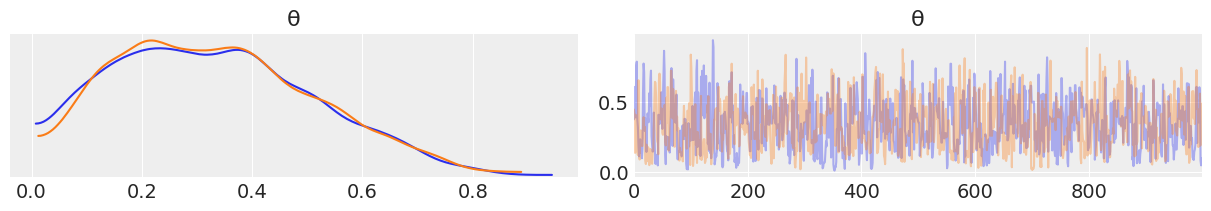

In [6]:
az.plot_trace(trace);

Obtenemos dos gráficas, ambas para la variable $\theta$. La gráfica de la izquierda es un KDE-plot (Kernel Density Estimation), es basicamente la versión continua de un histograma. A la derecha tenemos los valores muestreados en función de los pasos (1000 en este caso).

> Es importante notar que la variable `y` es una variable observada, es decir conocida. El `trace` contiene solo los valores de la variables desconocidas/muestreadas.

Si quisieramos un resúmen numérico de los resultados podemos usar:

In [7]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
θ,0.337342,0.180195,0.006093,0.027517,0.672378,821.902657,0.999653


Como resultado obtenemos un DataFrame con los valores de la media, la desviación estándar y el intervalo HPD 94% (hpd_3  hpd_97). Estas medidas son propiedades de la variable de interés mientras que las tres últimas son propiedades del muestreo.

* El error introducido por el método de muestreo
* El número efectivo de muestras
* El parámetro de Gelman-Rubin

Otra forma de resumir visualmente el a posteriori es usar la función `plot_posterior` que viene con ArviZ, ya hemos utilizado esta distribución en el capítulo anterior para un falso a posteriori. Vamos a usarlo ahora con un posterior real. Por defecto, esta función muestra un histograma para variables discretas y KDEs para variables continuas. También obtenemos la media de la distribución (podemos preguntar por la mediana o moda usando el argumento `point_estimate`) y el 95% HPD como una línea negra en la parte inferior de la gráfica. Se pueden establecer diferentes valores de intervalo para el HPD con el argumento `alpha`. Este tipo de gráfica fue presentado por John K. Kruschke en su gran libro "Doing Bayesian Data Analysis".

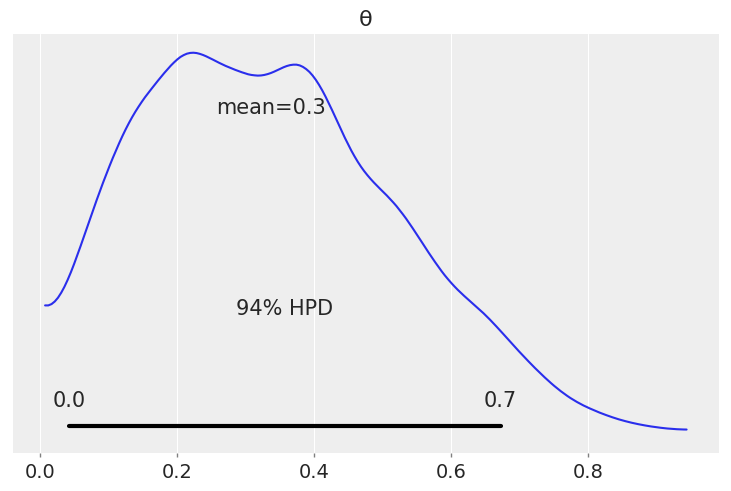

In [8]:
az.plot_posterior(trace);

## Decisiones basadas en el posterior

A veces describir el _a posteriori_ no es suficiente,  y es necesario tomar decisiones basadas en nuestras inferencias. Esto suele implicar reducir una estimación continua a una dicotómica: sí-no, enfermo-sano, contaminado-seguro, etc. Es posible, por ejemplo, que tengamos que decidir si la moneda está o no sesgada. Una moneda sesgada sería una que no caiga cara con probabilidad 0.5. Por lo tanto una forma de evaluar el sesgo es comparar el valor de referencia 0.5 contra el intervalo HPD. En la figura anterior, podemos ver que el HPD va de $\approx 0.02$ a $\approx 0.71$ y, por lo tanto, 0.5 está incluido en el HPD. Según el _a posterioriri_ la moneda parece estar sesgada hacia las cecas, pero no podemos descartar por completo el valor de 0.5. Si esta conclusión nos deja sabor a poco entonces tendremos que recopilar más datos para así reducir la varianza del _a posteriori_ o buscar información para definir un _a priori_ más informativo.

#### ROPE

Estrictamente la probabilidad de observar el valor exacto de 0.5 es nula, además en la práctica no nos suele interesar tener precisión infinita si no que solemos tener una idea del rango de error que es tolerable o despreciable. Una posibilidad consiste en definir lo que se conoce como _región de equivalencia práctica_ o ROPE (_Region Of Practical Equivalence_). Podríamos tener buenas razones para considerar que cualquier valor entre 0,45 y 0,55 es prácticamente equivalente a 0.5. No hay reglas generales para definir un ROPE ya que esta es una decisión contexto-dependiente. Para algunos problemas 0.05 podría ser mucho para otros poco, en algunos casos un rango simétrico es útil en otros es una mala idea.

Ya establecido la ROPE podemos usar las siguientes reglas para tomar una decisión:

* El valor de un parámetro es considerado improbable (o rechazado) si la totalidad de la ROPE cae por fuera del HPD 94% del parámetro en cuestión.

* El valor de un parámetro es aceptado si la ROPE contiene por completo al HPD 94% del parámetro en cuestión.

> Una ROPE es un intervalo arbitrario que se determina usando conocimiento previo y relevante sobre un tema. Cualquier valor dentro de este inervalo es considera equivalente.

Usando la función `plot_posterior` de ArviZ, podemos graficar el posterior junto con el HPD y la ROPE.

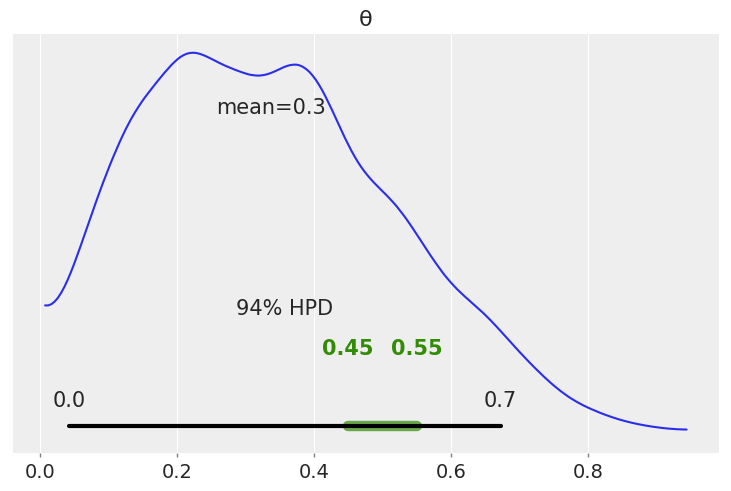

In [9]:
az.plot_posterior(trace, rope=[0.45, .55]); 

Otra herramienta que nos puede asistir en la toma de decisiones es comparar el _a posteriori_ con un valor de referencia. La función `plot_posterior` también nos permite hacer esto:

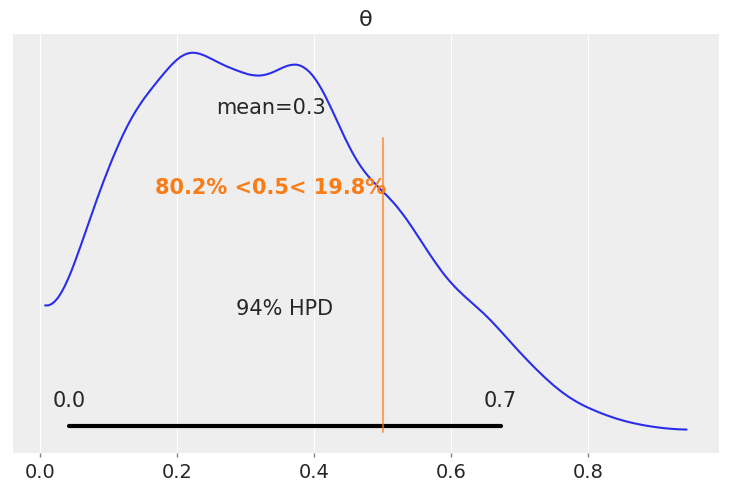

In [10]:
az.plot_posterior(trace, ref_val=0.5);

El valor de referencia está indicado con una linea naranja, junto con la proporción del posterior por debajo y por arriba del valor de referencia.

Para una discusión más detallada del uso de la ROPE pueden leer el capítulo 12 del gran libro _"Doing Bayesian Data Analysis"_ de John Kruschke. Este capítulo también discute cómo realizar pruebas de hipótesis de forma Bayesiana y los problemas de realizar este tipo de análisis, ya sea de forma Bayesiana o no-Bayesiana.

### Funciones de perdida

Una alternativa más _formal_ al uso de las ROPEs son las **Funciones de pérdida**. Para poder tomar la mejor decisión posible es necesario tener la mejor descripción posible de un problema y luego una evaluación correcta de los costos y beneficios. Bajo el marco Bayesiano lo primero implica obtener una distribución _a posteriori_, lo segundo se puede conseguir mediante la aplicación de una función de perdida. Una función de perdida es una forma de medir cuan distinta es una estimación respecto del valor _real_ (o de referencia) de un parámetro. Algunos ejemplos comunes son:

* La perdida cuadrática $(\theta - \hat \theta)^2$
* La perdida absoluta $|\theta - \hat \theta| $
* La perdida 0-1 $I(\theta \ne \hat{\theta})$ siendo $I$ la función indicatriz

La función de perdida (o su inversa) reciben diversos nombres según el campo de aplicación como funciones de costo, funciones objetivo, funciones de fitness (sic), funciones de utilidad, etc.

En la práctica generalmente desconocemos el valor correcto de $\theta$ y a duras penas tendremos un posterior adecuado, por lo tanto lo que se hace es tratar de encontrar el valor de $\hat \theta$ que minimice el **valor esperado** de la función de perdida. Esto implica promediar la función de perdida sobre todo el posterior, promediamos sobre el posterior porque desconocemos el valor de $\theta$.

En el siguiente ejemplo tenemos dos funciones de pérdida. La función absoluta `lossf_a` y la cuadrática `lossf_b`. Evaluamos cada una de las funciones para distintos valores de  $\hat \theta$ sobre una grilla de 200 puntos y encontramos el mínimo.

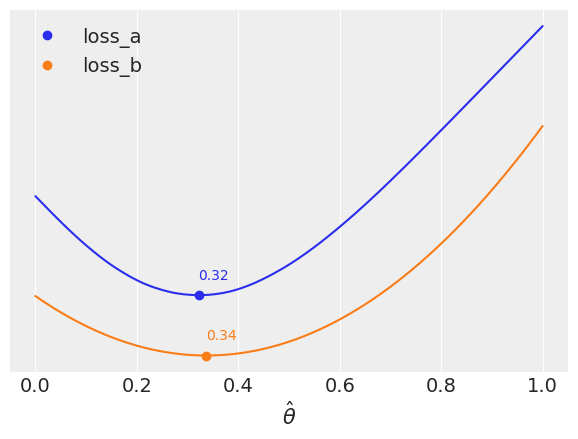

In [11]:
grid = np.linspace(0, 1, 200)
θ_pos = trace['θ']
lossf_a = [np.mean(abs(i - θ_pos)) for i in grid]
lossf_b = [np.mean((i - θ_pos)**2) for i in grid]

for i, (lossf, c) in enumerate(zip([lossf_a, lossf_b], ['C0', 'C1'])):
    mini = np.argmin(lossf)
    plt.plot(grid, lossf, c)
    plt.plot(grid[mini], lossf[mini], 'o', color=c, label='loss_' + ['a','b'][i])
    plt.annotate('{:.2f}'.format(grid[mini]), (grid[mini], lossf[mini] + 0.03), color=c)
    plt.yticks([])
    plt.xlabel(r'$\hat \theta$')
    plt.legend()

Las curvas son similares entre sí e incluso los mínimos son simialres, $\hat{\theta} \approx 0.31$ para `lossf_a` y $\hat{\theta} \approx 0.33$ para `lossf_b`

Lo que es interesante es que el primer valor se corresponde con la mediana del posterior y el segundo con su media. 

In [12]:
np.median(θ_pos), np.mean(θ_pos)

(0.3228316939702476, 0.3373423297141786)

Si bien esto no es una prueba formal, espero que haya sido un ejemplo lo suficientemente claro como para ilustrar el mensaje más importante de esta sección:

> Diferentes funciones de pérdida se relacionan con diferentes estimaciones puntuales

Por lo tanto, si queremos ser formales al momento de computar una estimación puntual, debemos decidir qué función de costo utilizar. O a la inversa, si elegimos una estimación puntual implicitamente estamos eligiendo una función de pérdida.

La ventaja de elegir explicitamente una función de perdida es que podemos ajustarla a las necesidades de un problema particular, en vez de utilizar un criterio predefinido. En muchos casos el costo asociado a una toma de decisión es asimétrico, esto es común en salud pública como sucede con vacunas o con la interrupción voluntaria del embarazo; procedimientos simples, baratos y seguros que previenen una gran cantidad de inconvenientes con un bajo riesgo de complicaciones.

Dado que, en general, el _a posteriori_ toma la forma de muestras finitas almacenadas en una computadora, es posible escribir código que refleje funciones de perdidas sin necesidad de estar acotado por la conveniencia matemática o la simplicidad. El siguiente es un ejemplo bastante pavo de esto.

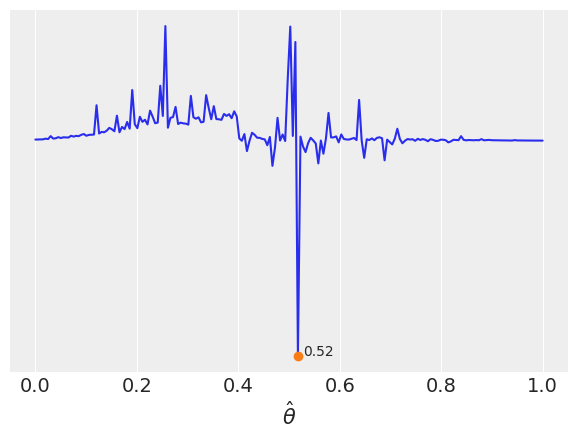

In [13]:
lossf = []
for i in grid:
    if i < 0.4:
        f = np.mean(np.pi * θ_pos / np.abs(i - θ_pos))
    else:
        f = np.mean(1 / (i - θ_pos))
    lossf.append(f)

mini = np.argmin(lossf)
plt.plot(grid, lossf)
plt.plot(grid[mini], lossf[mini], 'o')
plt.annotate('{:.2f}'.format(grid[mini]), (grid[mini] + 0.01, lossf[mini] + 0.1))
plt.yticks([])
plt.xlabel(r'$\hat \theta$');

Ahora bien, en la práctica no es cierto que todo el mundo elija una estimación puntual porque realmente acuerda, o tiene presente, alguna función de perdida en particular, en general la elección es por conveniencia, o tradición. Se usa la mediana porque es más robusta que la media a valores extremos o se usa la media porque es un concepto familiar y simple de entender, o porque pensamos que tal o cual observable es realmente un promedio de algún fenómeo subyacente (como moléculas golpeandose entre sí o genes interactuando con el ambiente).

## Modelos Multiparamétricos

Prácticamente todos los modelos de interés en estadística, son multiparamétricos, es decir modelos con más de un parámetro. 

Suele suceder que no todos los parámetros requeridos para construir un modelo son de interés, supongamos que quisiéramos estimar el valor medio de una distribución Gaussiana, a menos que sepamos el valor _real_ de la desviación estándar, nuestro modelo deberá contener un parámetro para la media y uno para la desviación estándar. Los parámetros que no son de inmediato interés pero son necesarios para definir un modelo de forma completa se llaman _nuisance parameters_ (o parámetro estorbo).

En estadística Bayesiana todos los parámetros tienen el mismo estatus, por lo que la diferencia entre _nuisance_ o no _nuisance_ no es fundamental bajo ningún concepto, sino que depende completamente de nuestras preguntas.

En principio podría parecer que incorporar parámetros que no nos interesan es un ejercicio de futilidad. Sin embargo, es todo lo contrario, al incorporar estos parámetros permitimos que la incertidumbre que tenemos sobre ellos se propague de forma adecuada a los resultados.

###  Inferencias lumínicas

A finales del siglo XIX Simon Newcomb realizó varios experimentos para determinar la velocidad de la luz. En uno de ellos Newcomb midió el tiempo que le tomaba a la luz recorrer 7442 metros. 

A continuación se muestra sus resultados, 66 mediciones.

In [14]:
datos = np.array([248.28, 248.26, 248.33, 248.24, 248.34, 247.56, 248.27, 248.16,
                  248.4, 247.98, 248.29, 248.22, 248.24, 248.21, 248.25, 248.3,
                  248.23, 248.29, 248.31, 248.19, 248.24, 248.2, 248.36, 248.32,
                  248.36, 248.28, 248.25, 248.21, 248.28, 248.29, 248.37, 248.25,
                  248.28, 248.26, 248.3, 248.32, 248.36, 248.26, 248.3, 248.22,
                  248.36, 248.23, 248.27, 248.27, 248.28, 248.27, 248.31, 248.27,
                  248.26, 248.33, 248.26, 248.32, 248.32, 248.24, 248.39, 248.28,
                  248.24, 248.25, 248.32, 248.25, 248.29, 248.27, 248.28, 248.29,
                  248.16, 248.23])

Si graficamos estas medidas veremos que la distribución parece Gaussiana excepto por dos medidas inusualmente bajas.

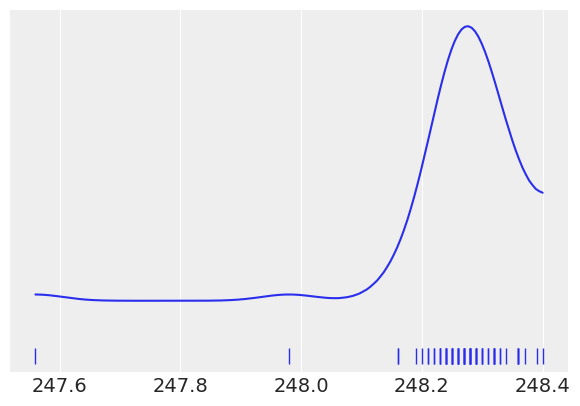

In [15]:
az.plot_kde(datos, rug=True)
plt.yticks([]);

Por simplicidad vamos a suponer que los datos siguen una distribución Gaussiana, después de todo es lo que en general se esperaría, en general, al medir una misma _cosa_ varias veces. Una distribución Gaussiana queda definida por dos parámetros, la media y la desviación estándar, como desconocemos estas dos cantidades necesitamos establecer dos _a prioris_ uno para cada parámetro. Un modelo probabilístico razonable sería el siguiente.


\begin{align} 
\mu &\sim U(l, h) \\
\sigma &\sim \text{Half-Normal}(\sigma_{\sigma}) \\
y &\sim \mathcal{N}(\mu, \sigma)
\end{align}


Es decir, $\mu$ proviene de una distribución uniforme entre los límites $l$ y $h$ y $\sigma$ proviene de una media-normal (_half-normal_) con desviación estándar $\sigma_{\sigma}$, esta distribución es como una Gaussiana pero restringida al rango $[0, \infty]$. Por último los datos $y$, como dijimos anteriormente, proviene de una distribución normal, especificada por $\mu$ y $\sigma$.

Si desconocemos por completo cuales podrían ser los valores de $\mu$ y de $\sigma$, podemos fijar valores para los _a prioris_ que reflejen nuestra ignorancia. 

Para la distribución uniforme una opción podría ser un intervalo con límite inferior de 0 y superior de 1 segundo. El límite inferior de 0 tiene sentido ya que las velocidades no pueden ser negativas, el límite superior de un 1 segundo es un valor elevado en la escala de los datos. Otra posibilidad sería usar los datos como guía por ejemplo $(l=datos.min() / 100, h=l+datos.min() * 100)$. De esta forma garantizamos que el _a priori_ contenga el rango de los datos pero que sea mucho más amplio, reflejando que no tenemos demasiado información para fijar un _a priori_ de forma más precisa. Los Bayesianos puristas consideran usar los datos para estimar _los a prioris_ ¡como alta traición! Ojo con las almas de cristal (¡en todo ámbito!).

Bajo ciertas condiciones los _a prioris_ uniformes puede ser problemáticos, tanto desde el punto de vista estadístico como computacional, por lo que se recomienda evitarlos, en general se recomienda evitar _a prioris_ con **límites**, como la distribución uniforme, a menos que tengamos información confiable sobre esos límites. Por ejemplo sabemos que las probabilidades están restringidas al intervalo [0, 1]. Pero no hay una buena razón para limitar la velocidad de la luz (bueno ¡no la había en los tiempos de Newcomb!). 

En la siguiente celda podrán ver que he elegido un par de _a prioris_ y hay otros comentados. Comparen cómo corre el modelo con los distintos _a prioris_, tanto en términos de los resultados como los tiempos y _calidad_ del muestreo.

In [16]:
with pm.Model() as modelo_g:
    # los a prioris
    μ = pm.Uniform('μ', 240, 250)
    #μ = pm.Normal('μ', 240, 100) # otro a priori alternativo
    σ = pm.HalfNormal('σ', sd=1)
    #σ = pm.HalfNormal('σ', sd=datos.std() * 100)
    # el likelihood
    y = pm.Normal('y', mu=μ, sd=σ, observed=datos)
    trace_g = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:01<00:00, 2285.48draws/s]


Como se puede ver el traceplot tiene ahora dos filas, una por cada parámetro. Cada una de estas filas corresponde a una variable _marginal_ del _a posteriori_ que en este caso es bi-dimensional.

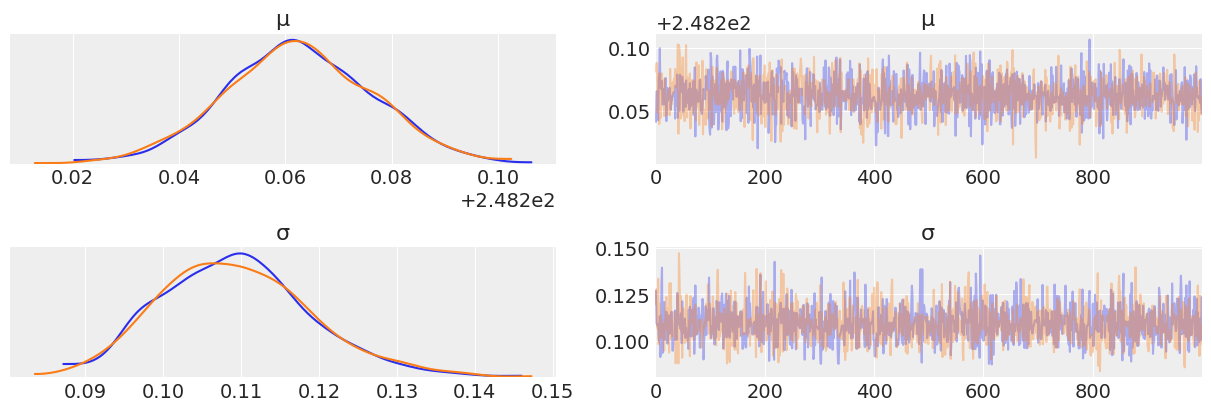

In [17]:
az.plot_trace(trace_g);

La siguiente figura muestra la distribución _a posteriori_ (que como ya mencionamos en bidimensional), junto con las distribuciones marginales para los parámetros $\mu$ y $\sigma$.

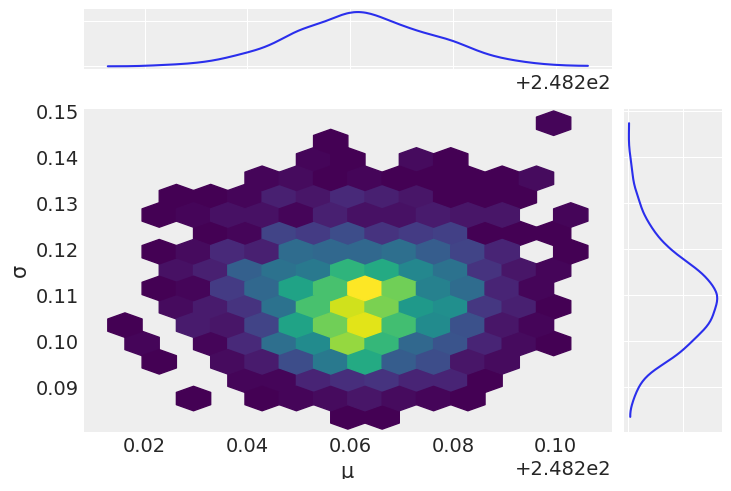

In [18]:
az.plot_joint(trace_g, kind='hexbin');

Una vez computado el _a posteriori_ podemos realizar diversos cálculos a partir de él. Uno de esos cálculos consiste en _simular datos_ ($\tilde{y}$). Matemáticamente lo que queremos calcular es:

\begin{equation}
p(\tilde{y} \,|\, y) = \int p(\tilde{y} \,|\, \theta) \, p(\theta \,|\, y) \, d\theta
\end{equation}


donde:

$y$ son los datos observados mientras que $\theta$ corresponde a los parámetros del modelo. 

Siguiendo el ejemplo de la velocidad de la luz, $\theta$ corresponde a $\mu$ y a $\sigma$. Computacionalmente podemos obtener $\tilde{y}$ de la siguiente forma:

1. Elegimos al azar un índice del `trace` generado por PyMC3 (un valor para $\mu_i$ y $\sigma_i$)
2. Generamos un _dato sintético_ usando el mismo _likelihood_ que usamos en el modelo, en este caso $\tilde{y_i}  \sim N(\mu_i, \sigma_i)$
3. Repetimos 1 y 2 hasta obtener la cantidad requerida de muestras.

Usando PyMC3 podemos calcular esto llamando a la función `sample_ppc`. El siguiente código devuelve 100 predicciones cada una de ellas de igual tamaño al de los datos.

In [19]:
ppc_g = pm.sample_ppc(trace_g, 100, modelo_g)

/home/osvaldo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  """Entry point for launching an IPython kernel.
100%|██████████| 100/100 [00:00<00:00, 1032.68it/s]


Los datos simulados los podemos usar para compararlos con los datos observados y de esta forma evaluar el modelo. Esto se conoce como prueba predictivas _a posteriori_, como ya adelantamos algo en el capítulo 1. En la siguiente gráfica la linea negra corresponde a los datos observados mientras que las lineas marrones (semitrasparentes) corresponden a datos predichos por el modelo.

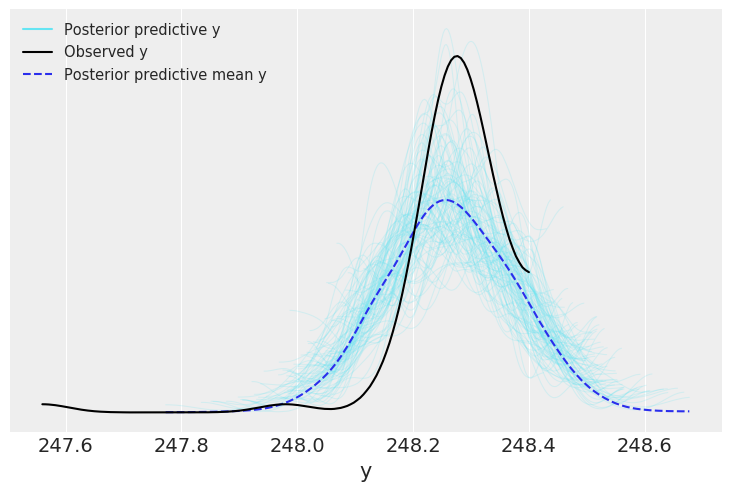

In [20]:
datos_ppc = az.from_pymc3(trace=trace_g, posterior_predictive=ppc_g)
az.plot_ppc(datos_ppc);

Según la gráfica anterior ¿Cuán bueno considerás que es nuestro modelo?

###  Modelos robustos

Un problema con el modelo anterior es que asume una distribución normal pero tenemos dos puntos que caen muy alejados de los valores medios. Esos puntos podrían estar alejados debido a errores experimentales en la toma de esos dos datos o podría haber un error al registrarlos o al trascribirlos. Si algo de esto sucedió podríamos justificar su eliminación de nuestro conjunto de datos (dejando registro de la eliminación y de las razones por las cuales lo hicimos). Otra opción es usar el rango inter-cuartil (u otro método _estadístico_) para declarar esos dos puntos como datos aberrantes ¡y desterrarlos de nuestros datos! Otra opción es dejarlos pero utilizar un modelo más robusto a valores alejados de la media. 

Uno de los inconvenientes al asumir normalidad, es que la media es muy sensible a valores aberrantes. La razón está en la colas de la Gaussiana, aún cuando las colas se extienden de $-\infty$ a $\infty$, la probabilidad de encontrar un valor cae rápidamente a medida que nos alejamos de la media, como se puede apreciar en la siguiente tabla que indica el porcentaje de valores que se encuentra a medida que nos alejamos de la media en unidades de desviación estándar (sd).

| sd |  % |
|:-:|:-:|
| 1 |  68 |
| 2 | 95  |
| 3 | 99.7 |
| 4 | 99.994 |
| 5 | 99.99994 |

Una alternativa a la distribución Gaussiana es usar una distribución t de Student, lo interesante de esta distribución es que además de estar definida por una media y una escala (análogo de la desviación estándar) está definida por un parámetro usualmente llamado $\nu$. $\nu$ es un parámetro que controla el grado de _normalidad_, ya que $\nu$ controla cuan _pesadas_ son las colas de la distribución. Cuando $\nu = 1$ (la distribución se llama de Cauchy o de Lorentz) las colas son muy pesadas, el 95% de los puntos está entre -12,7 y 12,7, en cambio en una Gaussiana (con desviación estándar 1) esto ocurre entre -1,96 y 1,96. En el límite de $\nu$ tendiendo a infinito estamos en presencia de una Gaussiana. La distribución t es realmente particular, cuando $\nu <= 1$ la distribución no tiene media definida y la varianza solo está definida para valores de $\nu > 2$.

La siguiente figura muestra una distribución t de Student para distintos valores de $\nu$.

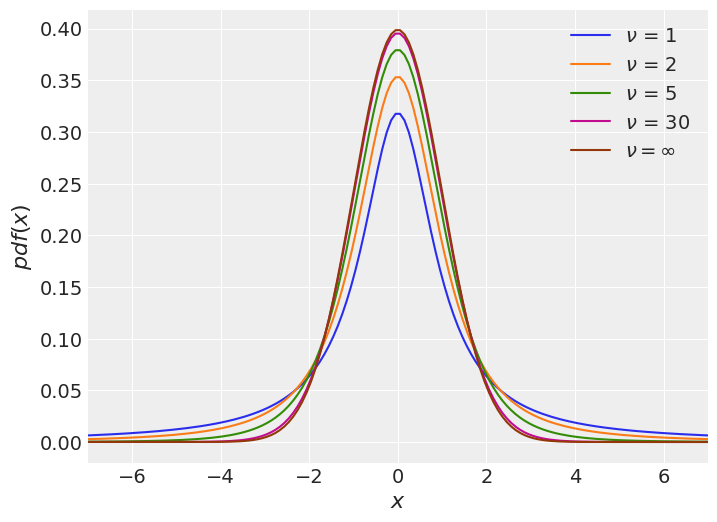

In [21]:
plt.figure(figsize=(8, 6))

x_values = np.linspace(-10, 10, 200)
for df in [1, 2, 5, 30]:
    distri = stats.t(df)
    x_pdf = distri.pdf(x_values)
    plt.plot(x_values, x_pdf, label=r'$\nu$ = {}'.format(df))

x_pdf = stats.norm.pdf(x_values)
plt.plot(x_values, x_pdf, label=r'$\nu = \infty$')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$pdf(x)$', rotation=90, fontsize=16)
plt.legend(loc=0, fontsize=14)
plt.xlim(-7, 7);

Ahora que conocemos la distribución t de Student, podemos usarla en nuestro modelo:

\begin{align}
\mu &\sim U(l, h) \\
\sigma &\sim \mathcal{HN}(\sigma_h) \\
\nu &\sim Expon(\lambda) \\
y &\sim StudentT(\mu, \sigma, \nu)
\end{align}

En algunos modelos puede ser buena idea sumar 1 a la distribución exponencial a fin de asegurarse que $\nu \ge 1$ . En principio $\nu$ puede tomar valores de [0, $\infty]$, pero en mi experiencia valores de $\nu < 1$ pueden traer problemas durante el muestreo, ya que pueden aparecer valores demasiado alejados de la media (las colas son extremadamente gordas!). Esto puede ocurrir con modelos con datos _marcadamente aberrantes_, veremos un ejemplo de esto en el capítulo 4.

Gráficamente:

<img src="img/velocidad_luz_t.png" width=400>

In [22]:
with pm.Model() as modelo_t:
    # los a prioris
    μ = pm.Uniform('μ', 240, 250)
    σ = pm.HalfNormal('σ', sd=1)
    ν = pm.Exponential('ν', 1/30)
    # el likelihood
    y = pm.StudentT('y', mu=μ, sd=σ, nu=ν, observed=datos)
    trace_t = pm.sample(1000 , tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ν, σ, μ]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:06<00:00, 609.22draws/s] 


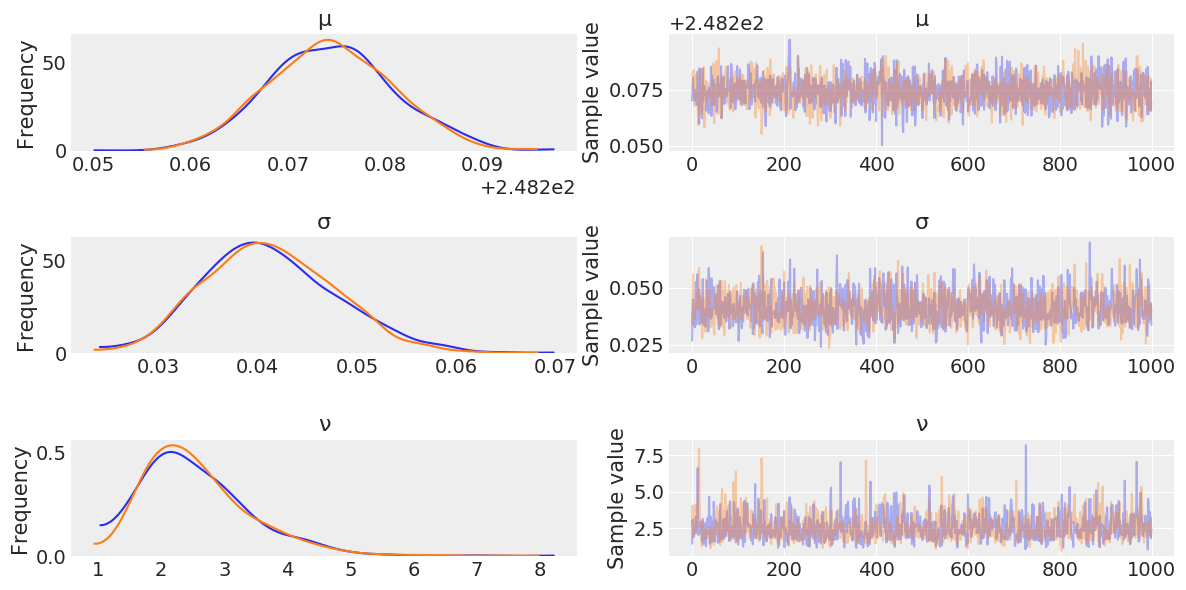

In [23]:
pm.traceplot(trace_t);

Comparemos las estimaciones entre ambos modelos

In [24]:
pm.summary(trace_g)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
μ,248.262263,0.013700,0.000310,248.234843,248.288291,2005.568579,0.999542
σ,0.109202,0.009599,0.000203,0.092836,0.130563,2087.072007,0.999502


In [25]:
pm.summary(trace_t)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
μ,248.274328,0.006355,0.000145,248.262332,248.286750,1752.527311,0.999526
σ,0.041247,0.006651,0.000186,0.028900,0.054402,1432.418526,0.999529
ν,2.579101,0.876294,0.026042,1.166074,4.261410,1175.133648,0.999514


En este caso, vemos que la estimación de $\mu$ es muy similar entre los dos modelos, aunque la estimación de $\sigma$, pasó de ser de ~10 a ~4. Esto es consecuencia de que la distribución t asigna menos peso a los valores alejados de la media que la distribución Gaussiana.

In [26]:
# sns.kdeplot(trace_t['μ'], trace_t['σ']);

Hagamos un prueba predictiva _a posteriori_ para el nuevo modelo.

In [27]:
ppc_t = pm.sample_ppc(trace_t, 100, modelo_t, size=len(datos))

/home/osvaldo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  """Entry point for launching an IPython kernel.
100%|██████████| 100/100 [00:00<00:00, 781.83it/s]


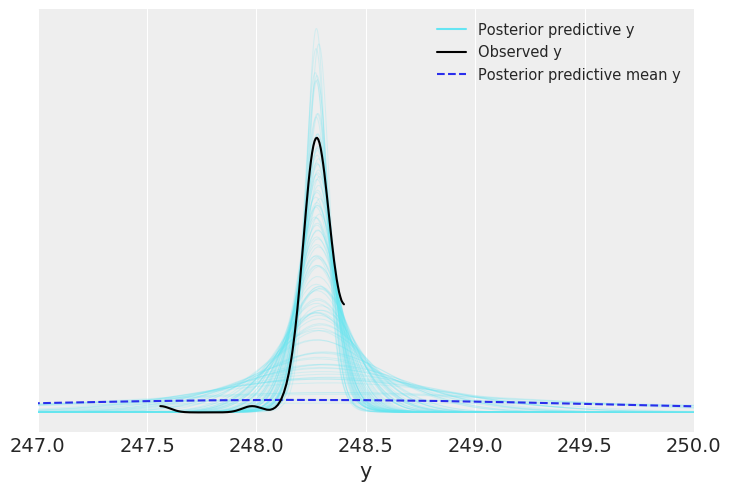

In [28]:
datos_ppc_t = az.from_pymc3(trace=trace_t, posterior_predictive=ppc_t)
az.plot_ppc(datos_ppc_t)
plt.xlim(247, 250);

¿Qué conclusión se puede sacar de comparar esta ppc con la anterior?

### Accidentes mineros

Este ejemplo está tomado del [tutorial](https://docs.pymc.io/notebooks/getting_started.html#Case-study-2:-Coal-mining-disasters) de PyMC3. 

El problema es el siguiente, tenemos un registro del número de accidentes en minas de carbón, ubicadas en el Reino Unido, que ocurrieron entre 1851 y 1962 ([Jarrett, 1979](http://biomet.oxfordjournals.org/content/66/1/191.abstract)). Se sospecha que la aplicación de ciertas regulaciones de seguridad tuvo como efecto una disminución en la cantidad de catástrofes. Por lo tanto nos interesa averiguar el año en que la tasa cambió y nos interesa estimar ambas tasas. 

Los datos son los siguientes, por un lado tenemos la variable _accidentes_ que contiene la cantidad de accidentes por año y por el otro la variable _años_ conteniendo el rango de años para los cuales tenemos datos. Si prestan atención verán que _accidentes_ es un arreglo enmascarado (o _masked array_). Esto es un tipo especial de arreglo de NumPy donde cada elemento del arreglo contiene asociado un valor _True_ o _False_ el cual indica si el elemento debe o no ser usado durante cualquier tipo de operación. En este caso como faltan datos para dos años lo que se ha hecho es marcar esa falta de datos con un valor centinela de -999, esta es la forma de indicarle a PyMC3 la presencia de datos faltantes, alternativamente se pueden pasar los datos como un _dataframe_ de Pandas conteniendo el valor especial `NAN` (que es el valor por defecto en Pandas para lidiar con datos faltantes).

Bien, pero para que molestarse con datos faltantes si en general es más fácil eliminarlos. una de las razones es que esto puede conducir a pérdida de información cuando por cada observación tenemos más de una variable o cantidad de interés. Por ejemplo si tenemos 50 sujetos a los que les hemos medido la presión, la temperatura y el ritmo cardíaco, pero sucede que para 4 de ellos no contamos con el datos de la presión (porque alguien se olvidó de medirlo o registrarlo, o porque el tensiómetro se rompió, o por lo que sea). Podemos eliminar esos cuatro sujetos del análisis y perder por lo tanto información sobre la presión y ritmo cardíaco, o podemos usar todos los datos disponibles y además estimar los valores de temperatura faltantes. En el contexto de la estadística Bayesiana los datos faltantes se tratan como un parámetro desconocido del modelo que puede ser estimado.

In [29]:
accidentes = np.ma.masked_values([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                                  3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                                  2, 2, 3, 4, 2, 1, 3, -999, 2, 1, 1, 1, 1, 3, 0, 0,
                                  1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                                  0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                                  3, 3, 1, -999, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                                  0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1], value=-999)
años = np.arange(1851, 1962)

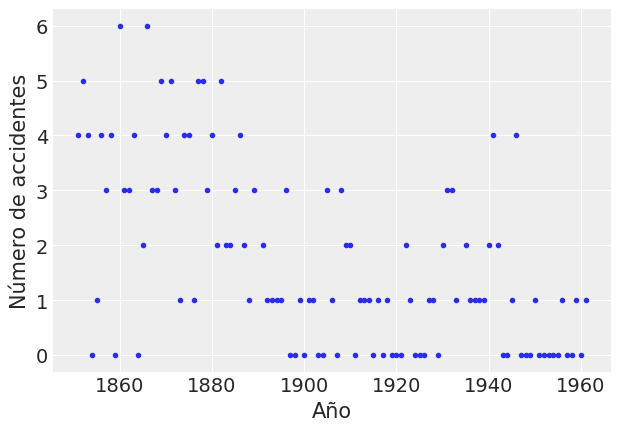

In [30]:
plt.plot(años, accidentes, '.')
plt.ylabel("Número de accidentes")
plt.xlabel("Año");

Para modelar los accidentes usaremos una distribución de Poisson. Como creemos que la cantidad media de accidentes es distinta antes y después de la introducción de regulaciones de seguridad usaremos dos valores de tasas medias de accidentes ($t_0$ y $t_1$). Además deberemos estimar un punto de corte ($pc$) que dividirá los años para los cuales se aplica la tasa de accidentes $t_0$ de los cuales se aplica la tasa $t_1$:

\begin{equation}
A_t \sim Poisson(tasa)
\end{equation}

\begin{equation}
tasa = \begin{cases}
t_0, \text{si } t \ge pc,\\
t_1, \text{si } t \lt pc
\end{cases}
\end{equation}

Los _a prioris_ que usaremos serán:

\begin{align}
t_0 \sim Expon(1) \\
t_1 \sim Expon(1) \\
pc \sim U(A_0, A_1)
\end{align}

Donde la distribucion uniforme es discreta y $A_0$ y $A_1$ corresponden al primer y último año considerado en el análisis respectivamente.


Gráficamente el modelo es:


<img src="img/modelo_mineros.png" width=350>



Una peculiaridad de la implementación de este modelo en PyMC3 es el uso de la función `pm.switch` (linea 10). Esta es en realidad una función de Theano y equivale a un _if else_ de Python. Si el primer argumento es _True_ entonces devuelve el segundo argumento caso contrario el tercer argumento. Como resultado tenemos que _tasa_ es un vector de longitud igual a la de _años_ y cuyos elementos corresponden a una repetición $t_0$ seguida de una repetición $t_1$, la cantidad exacta de repeticiones de $t_0$ y $t_1$ está controlada por la condición $pc \ge$ _años_. De esta forma, podemos al muestrear $pc$, modificar que años reciben cual tasa para el cálculo del _likelihood_.

In [31]:
with pm.Model() as modelo_cat:

    pc = pm.DiscreteUniform('pc', lower=años.min(), upper=años.max())

    # Priors para las tasas antes y después del cambio.
    t_0 = pm.Exponential('t_0', 1/10)
    t_1 = pm.Exponential('t_1', 1/10)

    # Asignamos las tasas a los años de acuerdo a pc
    tasa = pm.math.switch(pc >= años, t_0, t_1)

    acc = pm.Poisson('acc', tasa, observed=accidentes)
    trace_cat = pm.sample(5000)

/home/osvaldo/proyectos/00_PyMC3/pymc3/pymc3/model.py:1277: UserWarning: Data in acc contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, UserWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [acc_missing]
>>Metropolis: [pc]
>NUTS: [t_1, t_0]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:08<00:00, 1366.76draws/s]
The number of effective samples is smaller than 10% for some parameters.


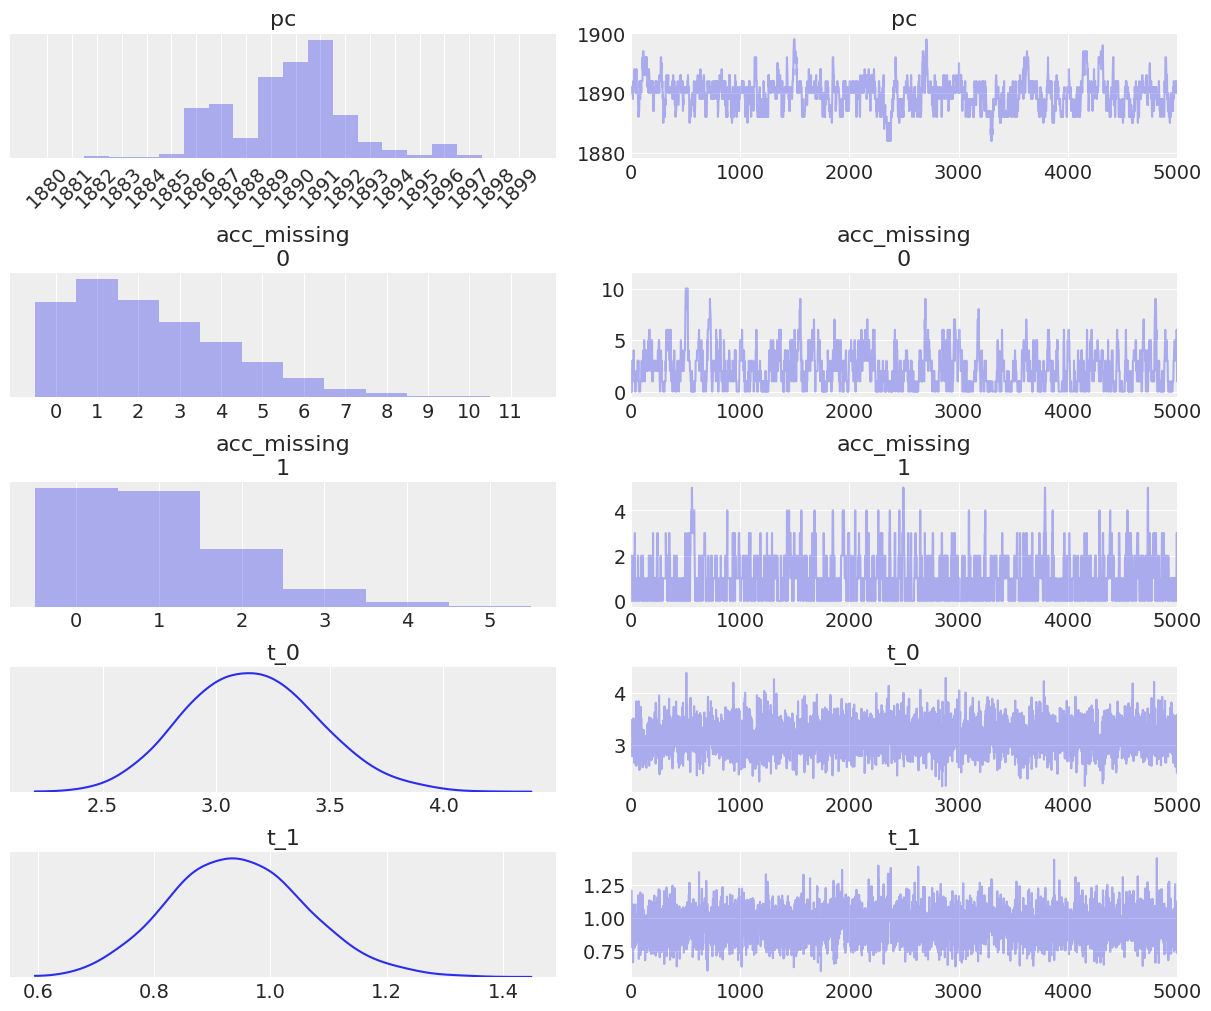

In [32]:
ax = az.plot_trace(trace_cat, combined=True);
[ticks.set_rotation(45) for ticks in ax[0, 0].get_xticklabels()];

In [33]:
pm.summary(trace_cat)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
pc,1889.764000,2.496699,0.109717,1885.000000,1895.000000,410.656655,1.001043
acc_missing__0,2.291800,1.934542,0.089775,0.000000,6.000000,377.577703,1.002511
acc_missing__1,0.969200,0.970593,0.030542,0.000000,3.000000,1039.595069,1.000351
t_0,3.159328,0.291190,0.004255,2.608085,3.731487,4455.580823,1.000146
t_1,0.945139,0.117599,0.001863,0.720000,1.178406,4670.312692,0.999927


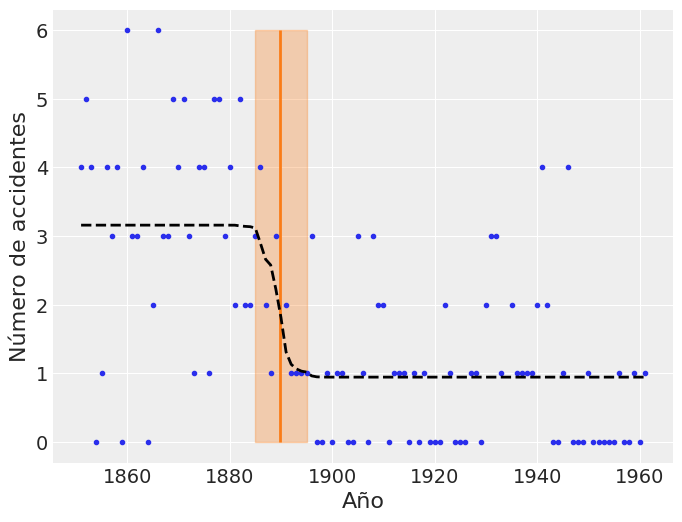

In [34]:
plt.figure(figsize=(8, 6))
plt.plot(años, accidentes, '.')
plt.ylabel("Número de accidentes", fontsize=16)
plt.xlabel("Año", fontsize=16)

plt.vlines(trace_cat['pc'].mean(), accidentes.min(), accidentes.max(), color='C1', lw=2)
accidentes_promedio = np.zeros_like(accidentes, dtype='float')
for i, año in enumerate(años):
    idx = año < trace_cat['pc']
    accidentes_promedio[i] = ((trace_cat['t_0'][idx].sum() + trace_cat['t_1'][~idx].sum()) 
                              / (len(trace_cat) * trace_cat.nchains))

pc_hpd = pm.hpd(trace_cat['pc'])
plt.fill_betweenx([accidentes.min(), accidentes.max()], pc_hpd[0], pc_hpd[1], alpha=0.3, color='C1');
plt.plot(años, accidentes_promedio,  'k--', lw=2);

## Comparando grupos

Una tarea común al analizar datos es comparar grupos. Podríamos estar interesados en analizar los resultados de un ensayo clínico donde se busca medir la efectividad de una droga, o la reducción de la cantidad de accidentes de tránsito al introducir un cambio en las regulaciones de tránsito, o el desempeño de estudiantes bajo diferentes aproximaciones pedagógicas, etc. Este tipo de preguntas se suele resolver en el marco de lo que se conoce como pruebas de hipótesis que busca declarar si una observación es estadísticamente significativa o no. Nosotros tomaremos una ruta alternativa. 

Al comparar grupos debemos decidir que característica(s) vamos a usar. Una característica común es la media de cada grupo. En ese caso podemos calcular la distribución _a posteriori_ de la diferencia entre medias. Para ayudarnos a entender este posterior usaremos 3 herramientas:


* Un _posteriorplot_ con un valor de referencia
* Una medida llamada _d de Cohen_ 
* La probabilidad de superioridad

En el capítulo anterior ya vimos un ejemplo de cómo usar _posteriorplot_ con un valor de referencia, pronto veremos otro ejemplo. Las novedades aquí son el d de Cohen y la probabilidad de superioridad, dos maneras populares de expresar el tamaño del efecto.

### d de Cohen

Una medida muy común, al menos en ciertas disciplinas, para cuantificar el tamaño del efecto es el d de Cohen

$$
\frac{\mu_2 - \mu_1}{\sqrt{\frac{\sigma_2^2 - \sigma_1^2}{2}}}
$$


De acuerdo con esta expresión, el tamaño del efecto es la diferencia de las medias con respecto a la desviación estándar combinada de ambos grupos. Ya que es posible obtener una distribución _a posteriori_ de medias y de desviaciones estándar, también es posible calcular una distribución _a posteriori_ de los valores d de Cohen. Por supuesto, si sólo necesitamos o queremos una estimación puntual, podríamos calcular la media de esa distribución _a posteriori_. En general, al calcular una desviación estándar combinada, se toma en cuenta el tamaño de la muestra de cada grupo explícitamente, pero la ecuación de _d de Cohen_ omite el tamaño de la muestra, la razón es que tomamos estos valores del _posterior_ (por lo que ya estamos considerando la incertidumbre de las desviaciones estándar).

> Un d de Cohen es una forma de medir el tamaño del efecto donde la diferencia de las medias se estandariza al considerar las desviaciones estándar de ambos grupos.

Cohen introduce la variabilidad de cada grupo al usar sus desviaciones estándar. Esto es realmente importante, una diferencia de 1 cuando la desviación estándar es de 0.1 es muy grande en comparación con la misma diferencia cuando la desviación estándar es 10. Además, un cambio de x unidades de un grupo respecto del otro podría explicarse por cada punto _desplazandose_ exactamente x unidades o la mitad de los puntos sin cambiar mientras la otra mitad cambia 2x unidades, y así con otras combinaciones. Por lo tanto, incluir las variaciones intrínsecas de los grupos es una forma de poner las diferencias en contexto. Re-escalar (estandarizar) las diferencias nos ayuda a dar sentido a la diferencia entre grupos y facilita evaluar si el cambio es importante, incluso cuando no estamos muy familiarizados con la escala utilizada para las mediciones.

Un d de Cohen se puede interpretar como un Z-score. Un Z-score es la cantidad de desviaciones estándar que un valor difiere del valor medio de lo que se está observando o midiendo, puede ser positivo o negativo dependiendo de si la diferencia es por exceso o por defecto. Por lo tanto, un d de Cohen de -1.2, indica que la media de un grupo está 1.2 desviación estándar por debajo de la media del otro grupo.


Incluso con las diferencias de medias estandarizadas, puede ser necesario tener que _calibrarnos_ en función del contexto de un problema determinado para poder decir si un valor de d de Cohen es _grande_, _pequeño_, _mediano_, _importante_, _despreciable_, etc. Afortunadamente, esta calibración se puede adquirir con la práctica, a modo de ejemplo si estamos acostumbrados a realizar varios análisis para más o menos el mismo tipo de problemas, podemos acostumbrarnos a un d de Cohen de entre 0.8 y 1.2, de modo que si obtenemos un valor de 2 podría ser que estamos frente a algo importante, inusual (¡o un error!). Una alternativa es consultar con expertos en el tema. 

Una muy buena página web para explorar cómo se ven los diferentes valores de Cohen's es http://rpsychologist.com/d3/cohend. En esa página, también encontrarán  otras formas de expresar el tamaño del efecto; algunas de ellos podrían ser más intuitivas, como la probabilidad de superioridad que analizaremos a continuación.


### Probabilidad de superioridad


Esta es otra forma de informar el tamaño del efecto y se define como la probabilidad que un dato tomado al azar de un grupo tenga un valor mayor que un punto tomado al azar del otro grupo. Si suponemos que los datos que estamos utilizando se distribuyen de forma Gaussiana, podemos calcular la probabilidad de superioridad a partir de la d de Cohen usando la expresión:

\begin{equation} \label{eq_ps}
ps = \Phi \left ( \frac{\delta}{\sqrt{2}} \right)
\end{equation}


Donde $\Phi$ es la distribución normal acumulada y $\delta$ es el d de Cohen. Podemos calcular una estimación puntual de la probabilidad de superioridad (lo que generalmente se informa) o podemos calcular la distribución _a posteriori_. Si no estamos de acuerdo con la suposición de normalidad, podemos descartar esta fórmula y calcularla directamente a partir del _posterior_ sin necesidad de asumir ninguna distribución. Esta es una de las ventajas de usar métodos de muestreo para estimar el _a posteriori_, una vez obtenidas las muestras lo que podemos hacer con ellas es muy flexible.

#### El conjunto de datos _tips_


Para explorar el tema de esta sección, vamos a usar el conjunto de datos tips (propinas). Estos datos fueron informados por primera vez por Bryant, P. G. and Smith, M (1995) _Practical Data Analysis: Case Studies in Business Statistics_.

Queremos estudiar el efecto del día de la semana sobre la cantidad de propinas en un restaurante. Para este ejemplo, los diferentes grupos son los días. Comencemos el análisis cargando el conjunto de datos como un DataFrame de Pandas usando solo una línea de código. Si no está familiarizado con Pandas, el comando _tail_ se usa para mostrar las últimas filas de un DataFrame:

In [35]:
tips = pd.read_csv('datos/propinas.csv')
tips.tail()

,total_bill,tip,sex,smoker,day,time,size
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2
243,18.78,3.00,Female,No,Thur,Dinner,2


Para este ejemplo solo vamos a usar las columnas `day` y `tip` y vamos a usar la función `plot_forest` de ArviZ. Aún cuando ArviZ está pensado para análisis de modelos Bayesianos algunos de sus funciones pueden ser útiles para analizar datos.

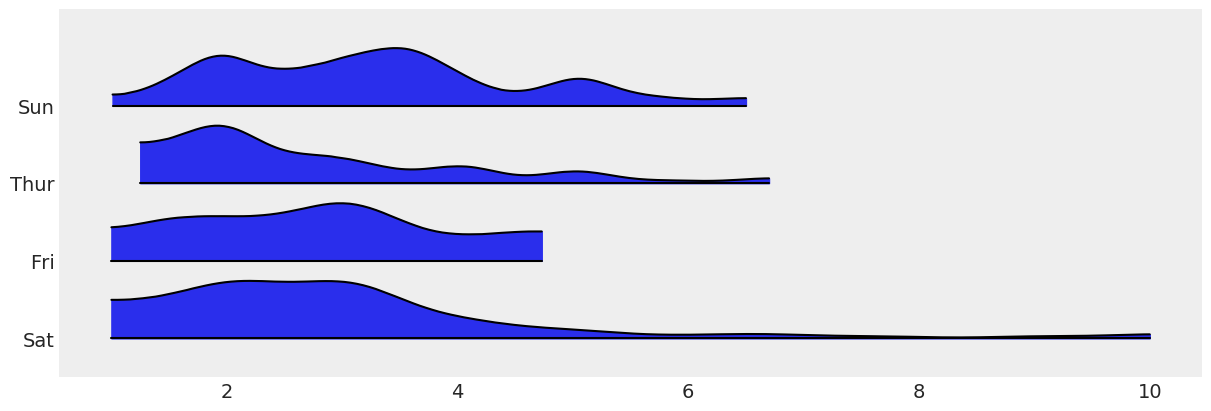

In [36]:
az.plot_forest(tips.pivot(columns='day', values='tip').to_dict('list'),
               kind='ridgeplot',
               figsize=(12, 4));

A fin de simplificar el análisis vamos a crear 3 variables:
* La variable `y` representando las propinas (en dolares).
* La variable `idx` que codifica los días de la semana [Thursday, Friday, Saturday, Sunday] como [0, 1, 2, 3].
* La variable `groups` el número de grupos.

In [37]:
categories=['Thur', 'Fri', 'Sat', 'Sun']

tip = tips['tip'].values
idx = pd.Categorical(tips['day'], categories=categories).codes
groups = len(np.unique(idx))

El modelo para este problema es basicamente igual a `model_g`, con la diferencia que $\mu$ y $\sigma$ ahora serán vectores en vez de escalares. La sintáxis de PyMC3 es super-útil para estos caso, en vez de usar `for loops` escribimos el modelo de forma vectorizada, para ello especificamos el argumento `shape` para los priors $\mu$ y $\sigma$ y para el likelihood usamos la variable `idx` para indexar de forma adecuada $\mu$ y $\sigma$ para asegurar que usamos los parámetros correctos para cada grupo. En este ejemplo un $\mu$ para jueves, otra para viernes otra para sábado y una cuarta para domingo, y lo mismo para $\sigma$.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:19<00:00, 576.49draws/s]


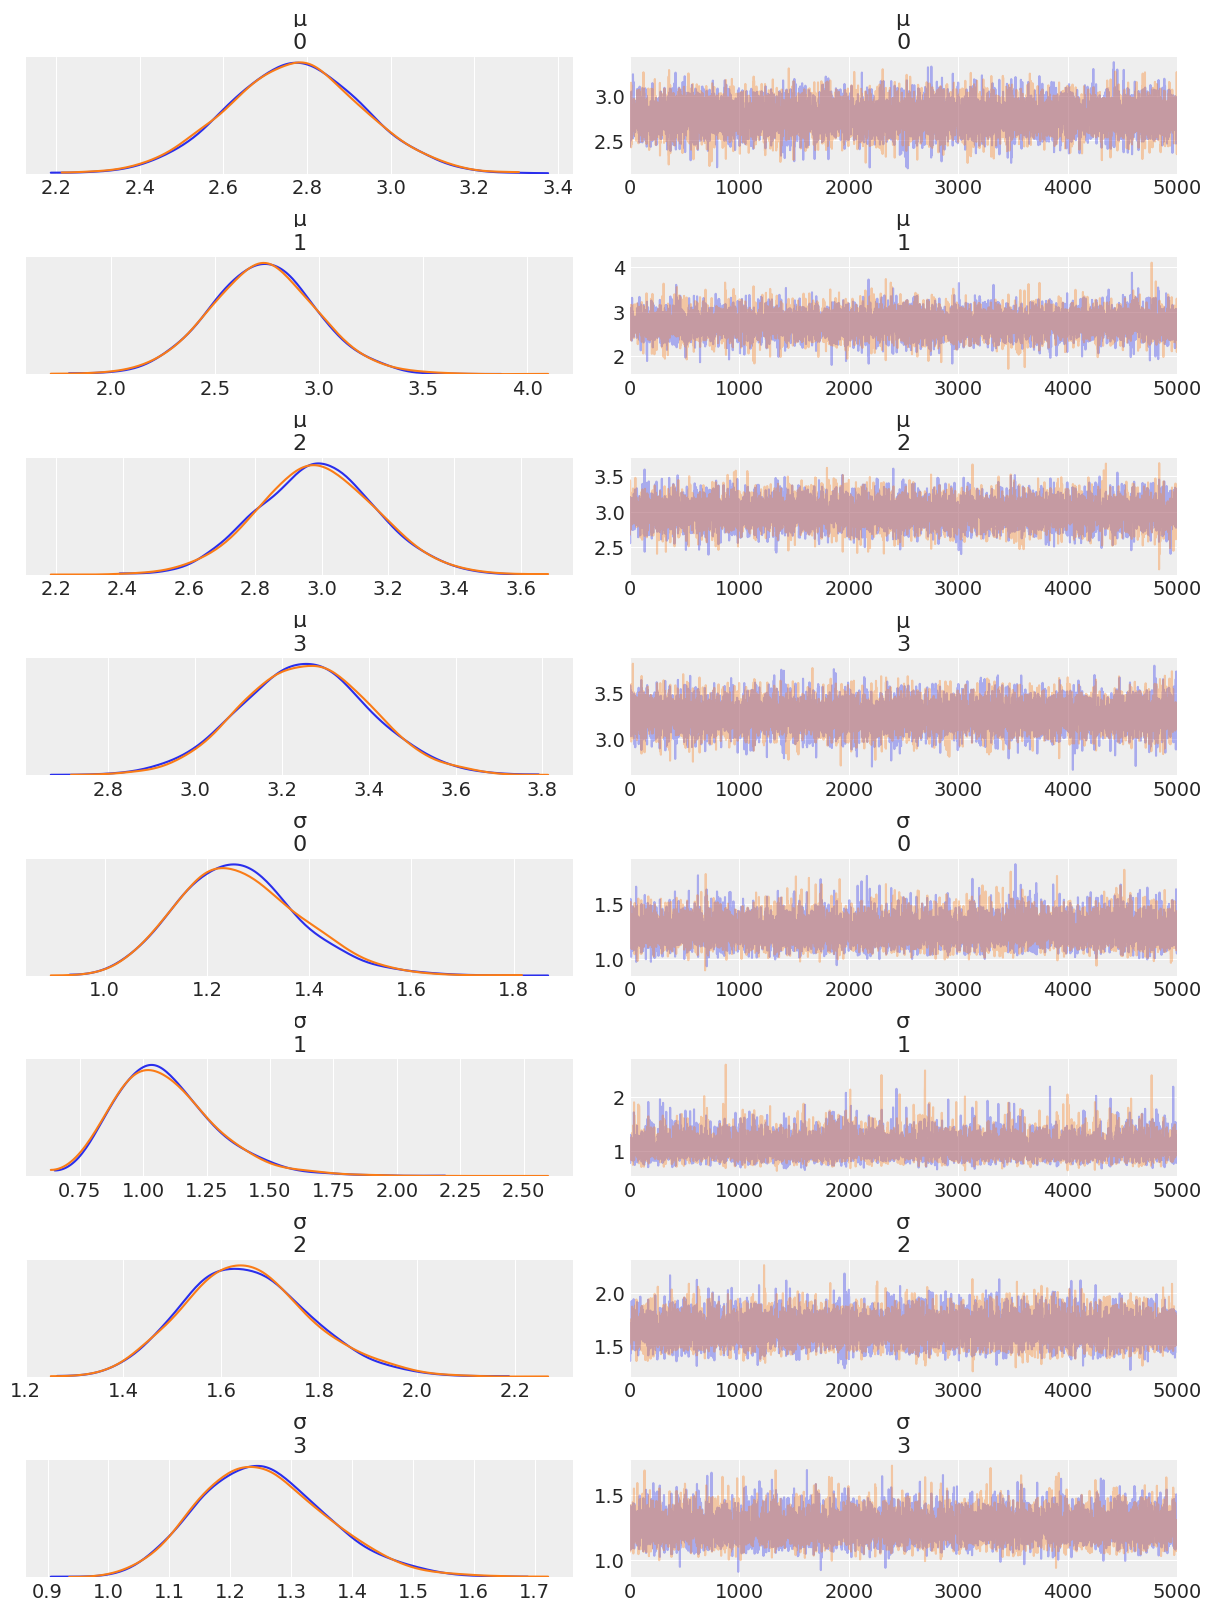

In [38]:
with pm.Model() as comparing_groups:
    μ = pm.Normal('μ', mu=0, sd=10, shape=groups)
    σ = pm.HalfNormal('σ', sd=10, shape=groups)

    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=tip)

    trace_cg = pm.sample(5000)
az.plot_trace(trace_cg);

In [39]:
# pm.summary(trace_cg)

Una vez obtenidos los _a posteriori_ podemos hacer todos los análisis que creamos pertinentes, por ejemplo, calcular todas las diferencias de medias _a posteriori_ entre si, junto con los valores correspondientes de la _probabilidad de superioridad_ y _d de Cohen_.

Con el siguiente código usamos `posterior_plot` para graficar las diferencias, en vez de graficar todas contra todas (que sería redundante), solo graficamos la porción tringular superior de la matriz.

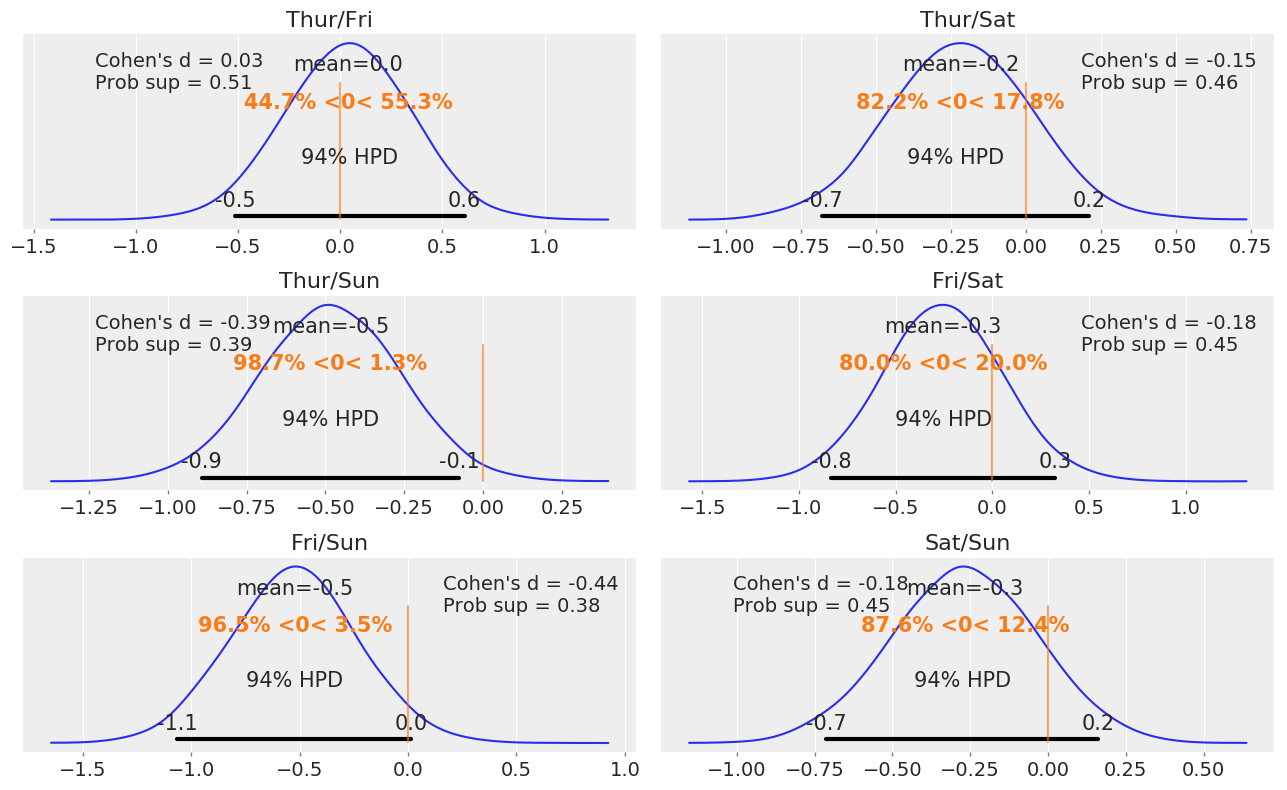

In [40]:
dist = stats.norm()

_, ax = plt.subplots(3, 2, figsize=(13, 8))

comparisons = [(i,j) for i in range(4) for j in range(i+1, 4)]
pos = [(k,l) for k in range(3) for l in (0, 1)]

for (i, j), (k,l) in zip(comparisons, pos):
    means_diff = trace_cg['μ'][:,i] - trace_cg['μ'][:,j]
    d_cohen = (means_diff / np.sqrt((trace_cg['σ'][:,i]**2 + trace_cg['σ'][:,j]**2) / 2)).mean()
    ps = dist.cdf(d_cohen/(2**0.5))
    az.plot_posterior(means_diff, ref_val=0, ax=ax[k, l])
    ax[k, l].set_title("%s/%s" % (categories[i], categories[j]))
    ax[k, l].plot(0, label="Cohen's d = {:.2f}\nProb sup = {:.2f}".format(d_cohen, ps), alpha=0)
    ax[k,l ].legend(fontsize=14)
plt.tight_layout()

Una forma de interpretar estos resultados es comparando el valor de referencia con el intervalo HPD. De acuerdo con la figura anterior, tenemos solo un caso cuando el 94% HPD excluye el valor de referencia de cero, la diferencia en las propinas entre el jueves y el domingo. Para todos los demás ejemplos, no podemos descartar una diferencia de cero (de acuerdo con los criterios de superposición de valores de referencia de HPD). Pero incluso para ese caso, ¿es una diferencia promedio de ≈0.5 dólares lo suficientemente grande? ¿Es suficiente esa diferencia para aceptar trabajar el domingo y perder la oportunidad de pasar tiempo con familiares o amigos? ¿Es suficiente esa diferencia para justificar promediar las propinas durante los cuatro días y dar a cada mozo/a la misma cantidad de dinero de propina? Ese tipo de preguntas no las puede responder la estadística solo pueden ser informadas por la estadística.

## Modelos Jerárquicos

El siguiente ejemplo está tomado del capítulo 9 del libro "Doing Bayesian Data Analysis" de John K. Kruschke. Supongamos que en vez de 1 moneda tenemos 3, supongamos además que sabemos que las tres monedas fueron echas con la misma matriz (en la misma fábrica). Para estimar el valor de $\theta$ tenemos dos opciones:

1) estimar un valor de $\theta$ para cada moneda por separado.

2) juntar las tres monedas en un mismo conjunto de datos y calcular un solo valor de $\theta$

La ventaja de la opción 1 es que las monedas podrían diferir entre sí por lo que calcular 3 valores de  $\theta$ podría ser muy informativo. La desventaja de este modelo es que hace caso omiso a la información que indica que las 3 monedas tienen un origen común, por lo que es probable que compartan características.

La ventaja de la opción 2 es que la cantidad de datos por parámetro aumentó, lo que reduce la incerteza. El problema es que pasamos a asumir que las 3 monedas son en realidad una, lo cual no sería problemático si las tres monedas fueran muy similares entre sí, pero esto podría no ser una buena aproximación.

Una tercera opción es hacer algo a mitad de camino entre 1 y 2. Esto se consigue construyendo un modelo jerárquico o modelo multinivel. Este tipo de modelo nos permitirá estimar un valor de $\theta$ para cada moneda de forma tal que la estimación de cada valor de $\theta$ influencie al resto.

En estadística Bayesiana construir modelos jerárquicos es sencillo. A continuación veremos que un modelo jerárquico para las 3 monedas es muy similar al usado para el caso de 1 sola moneda, solo que ahora colocamos un _a priori_ ¡sobre el _a priori_!

Recordemos, el modelo del capítulo anterior era:

\begin{align}
\theta &\sim \operatorname{Beta}(\alpha, \beta) \\
y &\sim \operatorname{Bin}(n=1, p=\theta)
\end{align}

En un modelo jerárquico los argumentos de la distribución Beta ($\alpha$ y $\beta$) no son constantes si no que son valores que proviene de alguna otra distribución. En nuestro modelo tendremos que:

\begin{align}
\mu &\sim \operatorname{Beta}(\alpha, \beta) \\
\kappa &\sim \operatorname{Gamma}(s, r) \\
\theta &\sim \operatorname{Beta}(\alpha=\mu  \kappa, \beta=(1 - \mu)  \kappa) \\
y &\sim \operatorname{Bin}(n=1, p=\theta)
\end{align}


Gráficamente, tenemos:

<img src="img/modelo_3_monedas_jerarquico.png" width=250>

En los modelos jerárquicos a los parámetros $\mu$ y a $\kappa$ se los llama _hiper a prioris_ o _hiperparámetros_ ya que son ellos quienes determinan el valor del _a priori_. La diferencia entre el modelo del capítulo anterior y el del presente es que ahora los valores que puede tomar $\theta$ dependen no ya de una distribución fija ($\alpha=1$ y $\beta=1$) si no de una distribución que depende de los valores de $\mu$ y $\kappa$, y que estimaremos a partir de los datos. Es decir es posible estimar el _a priori_ a partir de los datos, pero solo por que hemos introducido _hiper a prioris_. 

Recordarán que la distribución Beta se podía parametrizar en términos de $\alpha$ y $\beta$, pero también de $\mu$  y $\kappa$, donde $\mu$ es la media y $\kappa$ es la concentración (la inversa de la dispersión). Tenemos entonces que $\mu$ reflejará el valor promedio de 3 valores de $\theta$ y que si la proporción de caras en las tres monedas es similar entre si $\kappa$ tomara un valor más alto; mientras que si las monedas son diferentes entre si $\kappa$ tomará un valor más bajo.

### ¿Por qué la elección de los hiper _a prioris_?

Bueno dado que $\mu$ es la media del vector $\theta$ (y que $\theta$ solo puede tomar valores entre 0 y 1), $\mu$ queda restringida a valores entre 0 y 1 (al igual que una distribución beta), siguiendo el mismo razonamiento $\kappa$ va entre $[0, \infty]$ al igual que la distribución gamma. Otras distribuciones igualmente razonables podrían haber sido:

* $ \mu \sim U(0, 1)$
* $ \kappa \sim \mathcal{HN}(\sigma=100)$


Primero que nada generemos algunos datos sintéticos y los pondremos de una forma que sea más simple pasárselos al modelo, esto quedará un poco más claro al la especificación del modelo.

Vamos a suponer que con cada una de las 3 monedas hicimos 10 experimentos de Bernoulli (las arrojamos al aire) y obtuvimos como resultado, para cada caso, 5 caras.

In [41]:
N =  [10, 10, 10]  # Número de experimentos por moneda
z =  [5, 5, 5]  # [1, 5, 9]  # Número de caras en los Ni experimentos.

# vector conteniendo los índices para cada moneda (desde 0 al número de monedas)
monedas = np.repeat(np.arange(len(N)), N)
# lista con 1 para caras y 0 para cecas
datos = []  
for i, experimentos in enumerate(N):
    datos.extend(np.repeat([1, 0], [z[i], N[i]-z[i]]))

Como no sabemos demasiado sobre $\mu$ y $\kappa$, vamos a elegir $ \mu \sim \operatorname{Beta}(\alpha=2, \beta=2)$, lo que equivale a una distribución centrada en 0.5, pero que casi asigna la misma probabilidad a todos los valores entre 0 y 1. Y $ \kappa = \operatorname{Gamma}(s=1, r=0.1)$, lo que equivale a una curva con media y  desviación estándar 10.

La especificación del modelo es igual a lo que hemos venido haciendo, la única diferencia es que en la linea 8 podemos observar que hay un argumento llamando _shape_. Esto nos permite especificar las dimensiones de (en este caso) _$\theta$_. PyMC3 permite escribir modelos _vectorizados_ ahorrándonos el tener que escribir _for loops_. Esa es la razón por la cual en la celda superior creamos un vector _monedas_ que usamos en la linea 10 (de la especificación del modelo) para indexar _theta_.

In [42]:
with pm.Model() as modelo_j:
    # definimos los hiperparámetros
    μ = pm.Beta('μ', alpha=2, beta=2)
    κ = pm.Gamma('κ', alpha=1, beta=0.1)
    #κ = pm.Gamma('κ', mu=10, sd=10)
    
    # definimos el a priori
    θ = pm.Beta('θ', μ * κ, (1 - μ) * κ, shape=len(N))
    # definimos el likelihood
    y = pm.Bernoulli('y', p=θ[monedas], observed=datos)

    # muestreamos
    trace_j = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [θ, κ, μ]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:05<00:00, 984.90draws/s] 


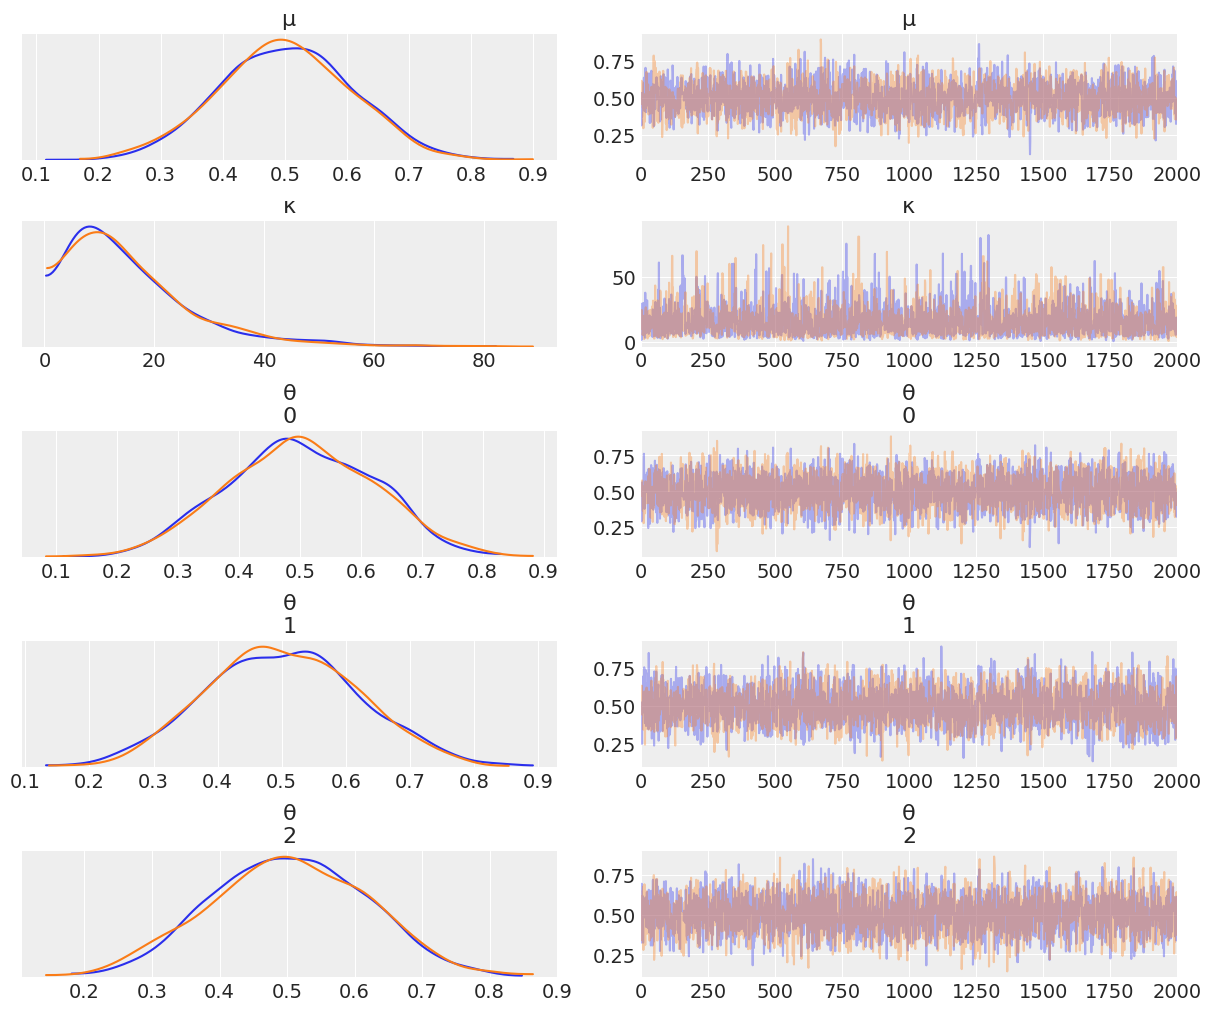

In [43]:
az.plot_trace(trace_j);

In [44]:
# az.plot_autocorr(trace_j);

In [45]:
pm.summary(trace_j)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
μ,0.499998,0.105521,0.001958,0.296073,0.702849,2399.906954,1.000288
κ,16.068606,12.025640,0.265281,0.838756,39.952220,2102.010979,0.999911
θ__0,0.499394,0.118687,0.002080,0.273370,0.725566,3193.841254,0.999809
θ__1,0.500473,0.117866,0.002216,0.266088,0.717955,2744.103374,0.999753
θ__2,0.501673,0.115583,0.001976,0.268994,0.712785,3081.686999,0.999791


Podemos observar que el valor de $\kappa$ del _a posteriori_ es mayor que del _a priori_. Esto es razonable ya que los experimentos con las 3 monedas han resultado idénticos, indicando que la matriz tiene un efecto importante sobre el resultado de $\theta$ para cada moneda.

¿Qué distribución hubiéramos obtenido para $\kappa$ si las monedas hubieran mostrado distintos resultados?
Probemos que hubiera pasado si:

```python
z = [1, 5, 9]
```

### Mirando el _a posteriori_ desde varios lados

El _a posteriori_ contiene toda la información que resulta de un análisis Bayesiano. Por lo que puede ser muy informativo analizarlo desde varios lados. Además de los gráficos que provee PyMC3, podemos analizar el _a posteriori_ usando nuestras propias gráficas, por ejemplo podemos estar interesados en observar como se correlacionan distintos parámetros.

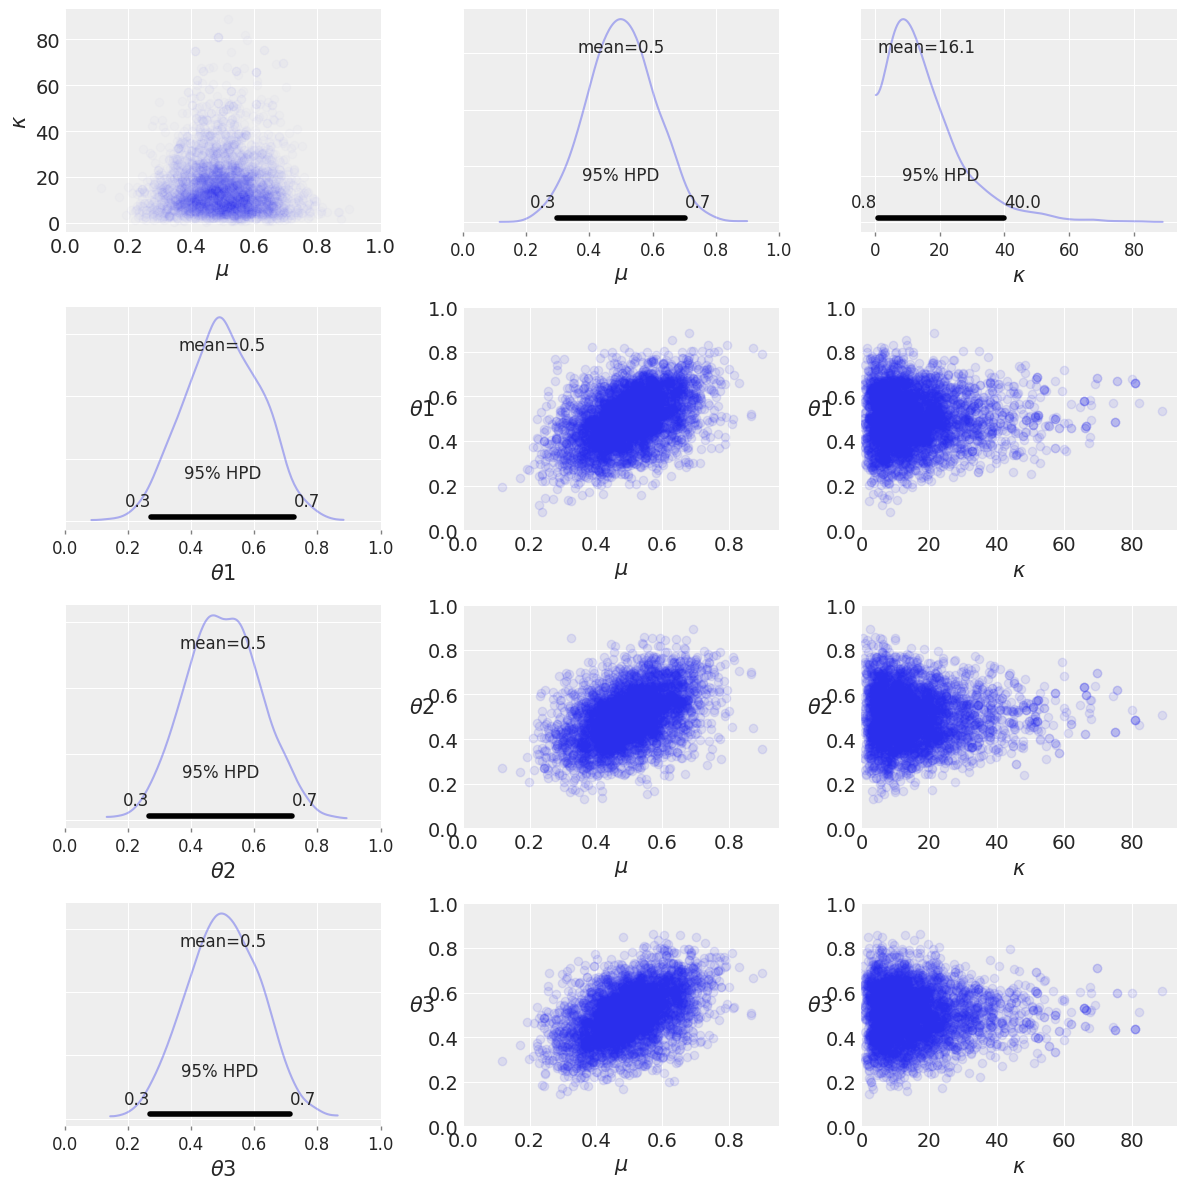

In [46]:
# Creamos arreglos tomando muestras del posterior
theta1_pos = trace_j['θ'][:,0]
theta2_pos = trace_j['θ'][:,1]
theta3_pos = trace_j['θ'][:,2]
mu_pos = trace_j['μ']
kappa_pos = trace_j['κ']

_, ax = plt.subplots(4, 3, figsize=(12, 12))

# Gráficos de dispersión de los hiper-parámetros
ax[0, 0].scatter(mu_pos, kappa_pos, marker='o', alpha=0.01)
ax[0, 0].set_xlim(0,1)
ax[0, 0].set_xlabel(r'$\mu$')
ax[0, 0].set_ylabel(r'$\kappa$')

pm.plot_posterior(mu_pos, ax=ax[0, 1], kde_plot=True, round_to=1)
ax[0, 1].set_xlabel(r'$\mu$')
ax[0, 1].set_xlim(0,1)

pm.plot_posterior(kappa_pos, ax=ax[0, 2], kde_plot=True, round_to=1)
ax[0, 2].set_xlabel(r'$\kappa$')
count = 1
for i, j in (theta1_pos, 'theta1'), (theta2_pos, 'theta2'), (theta3_pos, 'theta3'):
    pm.plot_posterior(i, ax=ax[count, 0], kde_plot=True, round_to=1)
    ax[count, 0].set_xlabel('$\{}$'.format(j))
    ax[count, 0].set_xlim(0,1)
    countb = 1
    for k, l in (mu_pos, 'mu'), (kappa_pos, 'kappa'):
        ax[count, countb].scatter(k, i, marker='o', alpha=0.1)
        ax[count, countb].set_xlabel('$\{}$'.format(l))
        ax[count, countb].set_ylabel('$\{}$'.format(j), rotation=0)
        ax[count, countb].set_xlim(0)
        ax[count, countb].set_ylim(0,1)
        countb += 1
    count += 1

plt.tight_layout();

### Contracción (_shrinking_)

Probemos ahora con otros ejemplos (puede ser conveniente guardar las figuras obtenidas con distintos nombres).

* z = [1,1,1] 
* z = [9,9,9] 
* z = [9,1,9]

¿Cuáles son los valores de $\theta$ obtenidos en cada caso? Es lo mismo el valor estimado de $\theta$ para una moneda cuando cae 1 de 10 veces caras (y las otras dos también), que cuando una moneda cae 1 de 10 veces caras y las otras dos caen 9 de 10 veces cara?

Como podrán ver si hacen el ejercicio ¡el valor estimado $\theta$ no es el mismo! ¿Por qué sucede esto?

Porque el modelo especifica que las monedas NO son independientes. El modelo asume que las 3 monedas provienen de una misma matriz, por lo tanto la estimación de $\theta$ para una moneda es afectada por las otras y al mismo tiempo afecta a las otras. Este fenómeno se llama contracción, la razón del nombre es que las estimaciones individuales tienden a contraerse alrededor del valor promedio de las 3 estimaciones (en nuestro modelo $\mu$) esto se hace mas evidente para los valores _aberrantes_. Si todas las monedas menos una indican un valor de $\theta$ más o menos similar la que posee el valor distinto tendrá un $\theta$ mucho más cercano al valor de las demás que si la hubiéramos estimado de forma individual.

Esto quizá pueda parecerles problemático, pero no es más que un reflejo de lo que asumimos al crear el modelo. La matriz con la que fueron echas las monedas influencia el sesgo de las mismas. Entonces, la estimación de cada elemento del vector $\theta$ debe influenciar y ser influenciado por las estimaciones de los demás elementos de $\theta$. Esto es una forma de regularización que los métodos frecuentistas deben introducir _ad-hoc_, pero que sin embargo ya viene incluido en un análisis Bayesiano.

Entonces el modelo jerárquico Bayesiano que hemos construido nos dice, no solo los valores de $\theta$, sino lo valores de $\mu$ (el sesgo promedio) introducido por la matriz y los valores de $\kappa$ (cuan fuerte es el efecto de la matriz sobre los sesgos individuales de $\theta$).

### Veamos otro ejemplo 


Las [proteínas](https://www.youtube.com/watch?v=wvTv8TqWC48) son moléculas formadas por 20 unidas, llamadas amino ácidos, cada amino ácido puede aparecer en una proteína 0 o más veces. Así como una melodía está definida por una sucesión de notas musicales, una proteína está definida por una sucesión de amino ácidos. Algunas variaciones de notas pueden dar como resultados pequeñas variaciones sobre la misma melodía, otras variaciones pueden resultar en melodías completamente distintas, algo similar sucede con las proteínas. Una forma de estudiar proteínas es usando resonancia magnética nuclear (la misma técnica usada para imágenes médicas). Esta técnica permite medir diversos _observables_, uno de ellos se llama _desplazamiento químico_ y para simplificar diremos que podemos medir tantos desplazamientos químicos como amino ácidos tenga una proteína. Los aminoácidos son una familia de compuestos químicos por lo que tendría sentido tratarlos a todos de igual forma, pero al mismo tiempo tienen diferentes propiedades químicas, las cuales de hecho son relevantes para comprender como funcionan las proteínas! Por lo que también tiene sentido tratarlos por separado. Como ya vimos una alternativa es construir un modelo jerárquico y hacer algo a mitad de camino.

El siguiente conjunto de datos contiene valores de desplazamientos químicos para un conjunto de proteínas. Si inspeccionan el DataFrame `cs_data` verán que tiene 4 columnas:

* La primera es un código que identifica a la proteína (pueden obtener muchísima información sobre esa proteína ingresando ese código en https://www.rcsb.org/.).
* La segunda columna tiene el nombre del amino ácido (pueden corroborar que hay tan solo 20 nombres únicos).
* La tercera contiene valores téoricos de desplazamientos químicos (calculados usando métodos cuánticos).
* La cuarta tiene valores experimentales.

La motivación de este ejemplo es comparar las diferencias entre valores teóricos y experimentales, entre otras razones para evaluar la capacidad de los métodos cuánticos para reproducir valores experimentales.


In [47]:
cs_data = pd.read_csv('datos/chemical_shifts_theo_exp.csv')
diff = cs_data.theo - cs_data.exp
idx = pd.Categorical(cs_data['aa']).codes
groups = len(np.unique(idx))

cs_data.tail()

,ID,aa,theo,exp
1771,1KS9,LYS,55.79,57.51
1772,1KS9,ARG,58.91,59.02
1773,1KS9,LYS,59.49,58.92
1774,1KS9,GLU,59.48,58.36
1775,1KS9,SER,58.07,60.55


Para resaltar la diferencia entre un modelo jerárquico y uno no-jerárquico vamos a construir ambos. Primero el no-jerárquico.

In [48]:
with pm.Model() as cs_nh:         
    μ = pm.Normal('μ', mu=0, sd=10, shape=groups) 
    σ = pm.HalfNormal('σ', sd=10, shape=groups) 
 
    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=diff) 
     
    trace_cs_nh = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:05<00:00, 560.51draws/s]


Y ahora el jerárquico.

Este modelo tiene un hyper-prior para la media de $\mu$ y otro para la desviación estándar de $\mu$. Para $\sigma$ no usamos un hyper-prior, es decir asumimos valores independientes. Esta es una decisión que tomé para simplificar el modelo, en principio no habría problema con usar un hyper-prior también para $\sigma$ o incluso  estimar un solo valor, compartido, de $\sigma$.

In [49]:
with pm.Model() as cs_h:
    # hyper_priors
    μ_mu = pm.Normal('μ_mu', mu=0, sd=10)
    μ_sd = pm.HalfNormal('μ_sd', 10)

    # priors
    μ = pm.Normal('μ', mu=μ_mu, sd=μ_sd, shape=groups) 
    σ = pm.HalfNormal('σ', sd=10, shape=groups) 

    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=diff) 

    trace_cs_h = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ, μ_sd, μ_mu]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:06<00:00, 493.48draws/s]


Vamos a comparar los resultados usando un `plot_forest`. ArviZ permite pasar más de un modelo. Esto es útil cuando queremos comparar los valores de parámetros equivalentes entre modelos como en el presente ejemplo. Noten que estamos pasando varios argumentos para obtener el gráfico, como por ejemplo `combined=True` que combina los resultados de todas las cadenas. Los invito a explorar el significado del resto de los parámetros.

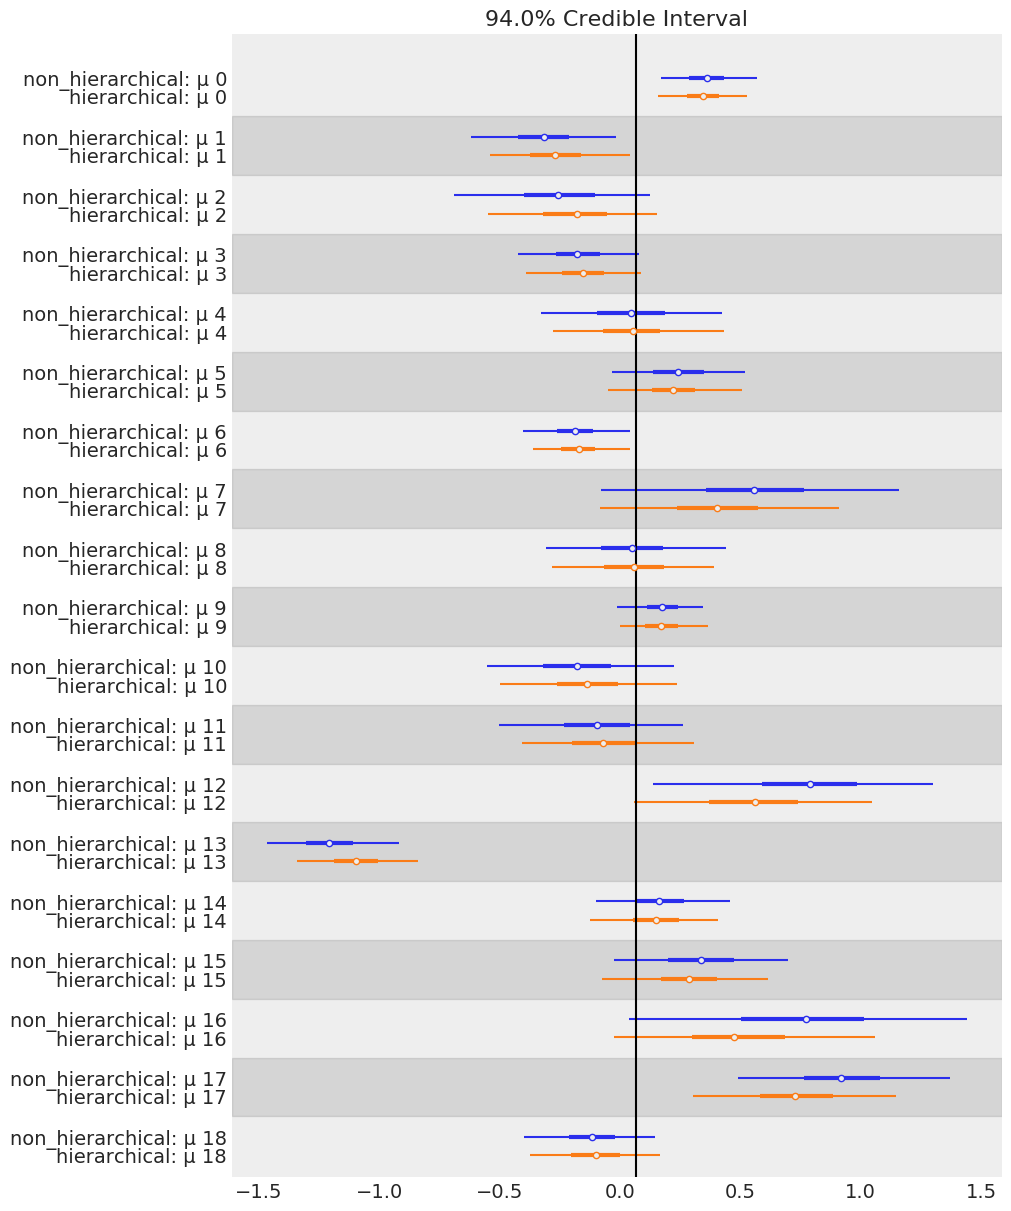

In [50]:
_, axes = az.plot_forest([trace_cs_nh, trace_cs_h], model_names=['non_hierarchical', 'hierarchical'],
              var_names='μ', combined=True, r_hat=False, ess=False, figsize=(10, 12),
              colors='cycle');
y_lims = axes[0].get_ylim()
axes[0].vlines(trace_cs_h['μ_mu'].mean(), *y_lims);

Bien, tenemos un gráfico para 40 valores medios estimados, uno por aminoácido (20) y esto duplicado ya que tenemos dos modelos. También tenemos los intervalos de credibilidad del 94% y el rango intercuartil (el intervalo que contiene el 50% central de la distribución). La línea vertical es la media parcialmente agrupada, es decir la media según el modelo jerárquico. El valor es cercano a cero, esto es parte de lo que esperaríamos ver si los valores teóricos son buenos reproduciendo los valores experimentales. 

La parte más relevante de este gráfico es que las estimaciones del modelo jerárquico son _atraidas_ hacia la media parcialmente agrupada o, de forma equivalente, se _contraen_ con respecto a las estimaciones no agrupadas. Este efecto es más notorio para los grupos más alejados de la media (como 13), además la incertidumbre es igual o menor que la del modelo no jerárquico. Decimos que las estimaciones están parcialmente agrupadas porque tenemos una estimación para cada grupo, pero las estimaciones para cada grupos se restringen mutuamente mediante el hiper prior. Por lo tanto, se obtiene una situación intermedia entre tener un solo grupo, todos los aminoácidos juntos, y tener 20 grupos separados, uno por aminoácido. 

Parafraseando el Zen de Python, podemos decir: _hierarchical models are one honking great idea - let's do more of those!_.

En los próximos capítulos, seguiremos construyendo modelos jerárquicos y aprendiendo cómo usarlos para construir mejores modelos. También discutiremos cómo se relacionan los modelos jerárquicos con uno de los problemas más comunes en estadística, ciencia de datos y _Machine learning_ el problema del overfitting/underfitting.

## Resumen

Aunque la estadística Bayesiana es conceptualmente simple, los modelos probabilísticos a menudo conducen a expresiones analíticamente intratables. Durante muchos años, esta fue una gran barrera que obstaculizó la adopción amplia de métodos Bayesianos. Afortunadamente, la matemática, la física y la informática vinieron al rescate en forma de métodos numéricos capaces, al menos en principio, de resolver cualquier inferencia. La posibilidad de automatizar el proceso de inferencia ha llevado al desarrollo de los lenguajes de programación probabilista que permiten una clara separación entre la definición del modelo y la inferencia.

PyMC3 es una librería de Python para programación probabilística con una sintaxis simple, intuitiva y fácil de leer que también está muy cerca de la sintaxis estadística utilizada para describir modelos probabilísticos. En este capítulo introducimos la biblioteca de PyMC3 revisando el problema de la moneda que vimos en el capítulo 1, pero esta vez sin derivar analíticamente la distribución  _a posteriori_. Los modelos en PyMC3 se definen dentro de un bloque `with`; para agregar una distribución de probabilidad a un modelo, solo necesitamos escribir una línea de código. Las distribuciones se pueden combinar y se pueden usar como priors (variables no observadas) o likelihoods (variables observadas), en la sintaxis de PyMC3 la única diferencia entre ambas es que para esta última pasamos los datos. PyMC3 nos permite obtener muestras de la distribución _a posteriori_, si todo va bien, estas muestras serán representativas de la distribución correcta y, por lo tanto, serán una representación de las consecuencias lógicas del modelo y los datos.

ArviZ es una librería que nos ayuda a explorar el posterior generado por PyMC3. Una forma de usar el posterior para ayudarnos a tomar decisiones es comparando la ROPE con el intervalo HPD. También mencionamos brevemente la noción de funciones de pérdida, una aproximación formal para cuantificar los costos y beneficios asociados a la toma de decisiones. Aprendimos que las funciones de pérdida y las estimaciones puntuales están íntimamente asociadas.

Hasta este momento todos los ejemplos estuvieron basado en modelos con un solo parámetro. Sin embargo PyMC3 permite, en principiop, usar un número arbitrario de parámetros, esto lo ejemplificamos con un modelo Gaussiano y luego una generalización de este, el modelo t de Student. La distribución t de Student suele usarse como alternativa a la Gaussiana cuando queremos hacer inferencias robustas a valores aberrantes. En el siguiente capítulo veremos cómo se puede usar este modelo como parte de los modelos de regresión lineal.

También usamos Gaussianas para modelar comparaciones entre grupos, una tarea común en análisis de datos. Si bien esto a veces se enmarca en el contexto de las pruebas de hipótesis, tomamos otra ruta y trabajamos este problema como una inferencia del tamaño del efecto, un enfoque que considero mucho más rico. También exploramos diferentes formas de interpretar e informar los tamaños del efecto.

Cerramos el capítulo con uno de los conceptos más importantes de este curso: los modelos jerárquicos. Podemos construir modelos jerárquicos cada vez que podamos identificar subgrupos en nuestros datos. En tales casos, en lugar de tratar los subgrupos como entidades separadas o ignorar los subgrupos y tratarlos como un solo gran-grupo, podemos construir un modelo para agrupar-parcialmente la información entre los grupos. El principal efecto de este agrupamiento-parcial es que las estimaciones de cada subgrupo estarán sesgadas por las estimaciones del resto de los subgrupos. Este efecto se conoce como contracción y, en general, es un truco muy útil que ayuda a mejorar las inferencias haciéndolas más conservadoras (ya que cada subgrupo informa a los demás acercando el resto de las estimaciones hacia él) y más informativas, obtenemos estimaciones a nivel de subgrupo y el nivel del grupo.

## Para seguir leyendo

* La [documentación de PyMC3](https://pymc-devs.github.io/pymc3/.) tiene varios ejemplos de como usar este librería y modelos de distinto tipo.  


* [Probabilistic Programming and Bayesian Methods for Hackers](https://github.com/quantopian/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers) de Cameron Davidson-Pilon y varios otros contribuidores. Originalmente escrito en PyMC2 ha sido portado a PyMC3 


* [While My MCMC Gently Samples](http://twiecki.github.io/.). Un blog de Thomas Wiecki, desarrollador de PyMC3.


* [Statistical Rethinking by Richard McElreath](https://xcelab.net/rm/statistical-rethinking/) es probablemente el mejor libro introductorio de estadística Bayesiana. El libro usa R/Stan. Pero varias personas hemos contribuido para [portar el código a Python/PyMC3](https://github.com/pymc-devs/resources/tree/master/Rethinking) 


* [Doing Bayesian Data Analysis](http://www.indiana.edu/~kruschke/DoingBayesianDataAnalysis/) de John K. Kruschke es otro libro introductorio bastante accesible. La mayoría de los ejemplos de la primer edición están disponibles en [Python/PyMC3](https://github.com/aloctavodia/Doing_bayesian_data_analysis) y de la segunda edición [acá](https://github.com/JWarmenhoven/DBDA-python).

## Ejercicios

1. Usando PyMC3 reproducí los resultados del primer capítulo para el problema de la moneda (use los 3 priors usados en ese capítulo).


2. Reemplazá la distribución beta por una uniforme en el intervalo [0, 1] ¿Cómo cambia la velocidad del muestreo? ¿Y si se usas un intervalo más ámplio, como [-3, 3]? 


3. Para el `modelo_g`. Usá una Gaussiana para la media, centrada en la media empírica. Probá modificar la desviación estándard de ese prior ¿Cuán robusto/sensible son los resultados a la elección del prior?


4. La Gaussiana es una distribución _sin límites_ es decir es válida en el intervalo $[-\infty, \infty]$, en el ejemplo anterior la usamos para modelar datos que sabemos tienen límites ¿Qué opinas de esta elección?


5. Usando los datos de la velocidad de la luz, calculá la media y desviación estándar con y sin los _outilers_, compará esos valores con los obtenidos con el `modelo_g` y con el `modelo_t`.
  

6. Modificá el modelo de las propinas para usar una distribución t de Student, probá usando un solo $\nu$ para los cuatro grupos y también usando un valor de $\nu$ por grupo.


7. Calculá la probabilidad de superioridad a partir de las muestras del posterior (sin usar la formula de probabilidad de superioridad a partir de la d de Cohen). Comparar los resultados con los valores obtenidos a analíticamente.


8. Repetí el ejercicio que hicimos con el `model_j`, pero sin la estructura jerárquica. Compará los resultados con los obtenidos de forma jerárquica.


9. Crea una versión jerárquica para el ejemplo de las propinas agrupando parcialmente los días de la semana. 


10. Aplica al menos uno de los modelos visto en este capítulo a datos propios o de tu interés.